# Projet Credit Scoring
**Auteur :** Paul HOCHENAUER

Ce notebook présente l'analyse exploratoire et la modélisation du risque de défaut de crédit.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import seaborn as sns
import re

### Chargement et exploration initiale des données

In [4]:
# Chargement des fichiers
df = pd.read_csv("/content/sample_data/TD3 - 12Janv.csv")
data_dict = pd.read_csv("/content/sample_data/data_dictionary.csv")

display(HTML("<h3>0. Dictionnaire des Variables</h3>"))
display(HTML("<p>Description de toutes les variables disponibles dans le jeu de données.</p>"))

# On affiche le dictionnaire complet
display(data_dict.style.set_properties(**{'text-align': 'left'}).hide(axis='index'))

# Vue globale du dataset ie le dashboard
# Calcul des métriques globales du dataset
total_cells = np.prod(df.shape)
missing_cells = df.isnull().sum().sum()
missing_ratio = (missing_cells / total_cells) * 100
duplicates = df.duplicated().sum()

# Création d'un petit DataFrame pour l'affichage
overview_data = {
    'Indicateur': [
        'Nombre d\'observations (Lignes)',
        'Nombre de variables (Colonnes)',
        'Cellules Manquantes (Total)',
        'Pourcentage Manquant',
        'Lignes Dupliquées'
    ],
    'Valeur': [
        f"{df.shape[0]:,}".replace(',', ' '), # Format avec espace pour milliers
        df.shape[1],
        f"{missing_cells:,}".replace(',', ' '),
        f"{missing_ratio:.2f} %",
        duplicates
    ]
}

df_overview = pd.DataFrame(overview_data)

# Affichage d'un tableau de synthèse
display(HTML("<h3>1. Synthèse Globale du Jeu de Données</h3>"))
display(df_overview.style.hide(axis='index')
        .set_properties(**{'text-align': 'left', 'font-size': '14px'})
        .set_table_styles([{'selector': 'th', 'props': [('background-color', '#4CAF50'), ('color', 'white')]}]))

Variable Name,Description
UniqueID,Identifier for customers
loan_default,Payment default in the first EMI on due date
disbursed_amount,Amount of Loan disbursed
asset_cost,Cost of the Asset
ltv,Loan to Value of the asset
branch_id,Branch where the loan was disbursed
supplier_id,Vehicle Dealer where the loan was disbursed
manufacturer_id,"Vehicle manufacturer(Hero, Honda, TVS etc.)"
Current_pincode,Current pincode of the customer
Date.of.Birth,Date of birth of the customer


Indicateur,Valeur
Nombre d'observations (Lignes),1 639
Nombre de variables (Colonnes),27
Cellules Manquantes (Total),45
Pourcentage Manquant,0.10 %
Lignes Dupliquées,0


Le jeu de données est de taille modérée mais suffisante pour une analyse statistique avec 1639 observations ie 1639 clients et 27 variables descriptives présentées ci-dessus.

Le dataset est très propre pour un data sans cleaning pour l'instant. Le taux de données manquantes est infime uniquement de 0.10%, soit seulement 45 cellules sur plus de 44 000, ce qui indique une très bonne qualité de collecte.
Il n'y a aucun doublon avec 0 lignes dupliquées, ce qui évite les biais de répétition. Ainsi, nous disposons d'une base saine qui nécessitera très peu de pré-traitement / nettoyage avant la modélisation.

---


    

    

    

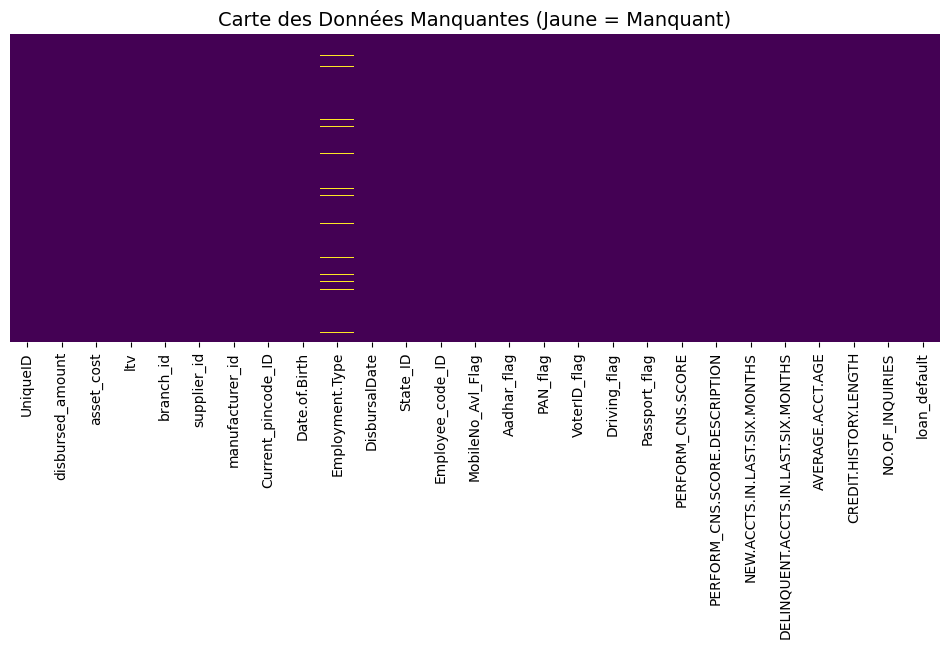

In [5]:
# Visualisation des données manquantes
# S'il y a des données manquantes, on affiche où elles se trouvent
if missing_cells > 0:
    plt.figure(figsize=(12, 4))
    sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
    plt.title('Carte des Données Manquantes (Jaune = Manquant)', fontsize=14)
    plt.show()
else:
    display(HTML("<p style='color:green; font-weight:bold;'>Aucune donnée manquante détectée (Clean Dataset).</p>"))




La visualisation confirme le constat précédent : la carte est presque entièrement de couleur uniforme, ce qui signifie que les données sont complètes pour la quasi-totalité des variables. Les quelques points jaunes ie les données manquantes sont probablement localisés sur la variable Employment.Type, ce qui est fréquent lorsque l'information n'est pas renseignée par le client.

Nous pourrons soit supprimer ces quelques lignes, soit les remplacer par la valeur la plus fréquente sans risquer de biaiser l'analyse. Par la suite, on va supprimer les lignes contenant une valeur null pour le Employment.Type.

---

### Affichage des différents types de variables

In [6]:
display(HTML("<h3>2. Types des Variables</h3>"))

# Séparation des colonnes
numeric_cols = df.select_dtypes(include=[np.number]).columns
object_cols = df.select_dtypes(include=['object']).columns

# Tableau des variables NUMÉRIQUES
display(HTML("<h4>a) Variables Numériques</h4>"))
# On crée un résumé : nom, type, nombren, manquant, moyenne, min, max
num_summary = df[numeric_cols].describe().transpose()[['count', 'mean', 'min', 'max']]
num_summary['Type'] = 'Numeric'
display(num_summary.style.background_gradient(cmap='Blues', subset=['mean']))

# Tableau des variables CHARACTER ie catégorielles
display(HTML("<h4>b) Variables de Type 'Character' (Texte)</h4>"))
# Pour le texte, on regarde le nombre de valeurs uniques et la valeur la plus fréquente
obj_summary = df[object_cols].describe().transpose()[['count', 'unique', 'top', 'freq']]
obj_summary['Type'] = 'Character/Object'
display(obj_summary.style.background_gradient(cmap='Reds', subset=['unique']))

# On affiche un échantillon des colonnes problématiques + cible
display(HTML("<h3>3. Aperçu brut (Identification des formats à retravailler)</h3>"))
cols_to_check = ['UniqueID', 'disbursed_amount', 'Date.of.Birth', 'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'loan_default']
display(df[cols_to_check].head())

,count,mean,min,max,Type
ltv,1639.000000,75.313801,25.720000,94.950000,Numeric
branch_id,1639.000000,71.482001,1.000000,260.000000,Numeric
manufacturer_id,1639.000000,69.600976,45.000000,145.000000,Numeric
State_ID,1639.000000,6.962782,1.000000,21.000000,Numeric
MobileNo_Avl_Flag,1639.000000,1.000000,1.000000,1.000000,Numeric
Aadhar_flag,1639.000000,0.832215,0.000000,1.000000,Numeric
PAN_flag,1639.000000,0.075656,0.000000,1.000000,Numeric
VoterID_flag,1639.000000,0.146431,0.000000,1.000000,Numeric
Driving_flag,1639.000000,0.030506,0.000000,1.000000,Numeric
Passport_flag,1639.000000,0.002441,0.000000,1.000000,Numeric


,count,unique,top,freq,Type
UniqueID,1639,1639,491879,1,Character/Object
disbursed_amount,1639,947,48349,18,Character/Object
asset_cost,1639,1494,68000,7,Character/Object
supplier_id,1639,882,14234,13,Character/Object
Current_pincode_ID,1639,1104,2578,17,Character/Object
Date.of.Birth,1639,1216,01/01/1990,18,Character/Object
Employment.Type,1594,2,Self employed,908,Character/Object
DisbursalDate,1639,83,31/10/2018,79,Character/Object
Employee_code_ID,1639,1183,255,6,Character/Object
PERFORM_CNS.SCORE.DESCRIPTION,1639,19,No Bureau History Available,376,Character/Object


,UniqueID,disbursed_amount,Date.of.Birth,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,loan_default
0,607719,58973,04/06/1966,3yrs 4mon,8yrs 9mon,0
1,511714,83686,24/02/1987,1yrs 0mon,2yrs 1mon,0
2,546989,67169,01/01/1983,1yrs 3mon,2yrs 11mon,0
3,631672,60583,30/06/1990,1yrs 1mon,2yrs 2mon,0
4,570056,62863,17/01/1969,1yrs 4mon,3yrs 0mon,0


Le jeu de données comprend des variables numériques et textuelles.

Les variables numériques, au nombre de 1639 observations, incluent des mesures financières comme le ltv, des identifiants, des indicateurs binaires ainsi que des scores de crédit et des variables liées au comportement financier récent.

Les variables textuelles regroupent des identifiants uniques, des montants et des dates au format texte à convertir, ainsi que des durées exprimées en années et mois (ex. « 3yrs 4mon ») qui nécessitent une transformation en valeurs numériques. Certaines variables catégorielles comme Employment.Type et PERFORM_CNS.SCORE.DESCRIPTION sont également présentes.

Un aperçu brut montre que plusieurs colonnes, notamment les dates, montants et durées, doivent être nettoyées et converties en formats adaptés avant analyse.

---

### Deep Dive : wrangling et mise en forme

**"Garbage in, garbage out"** : La qualité du modèle dépend de la qualité des données en entrée.
Dans cette section, nous allons :
 -  **Regrouper les modalités** du score de crédit (trop fragmentées) en niveaux de risque interprétables (low, medium, high).
 - **Convertir les dates** en durées (âge, ancienneté du prêt) pour capturer la notion de temporalité.

Regroupement des scores (binning)

Impact du regroupement des scores sur le défaut


loan_default,0,1
Risk_Category,,
High,44.0%,56.0%
Low,85.1%,14.9%
Medium,67.6%,32.4%
Not Scored,75.9%,24.1%


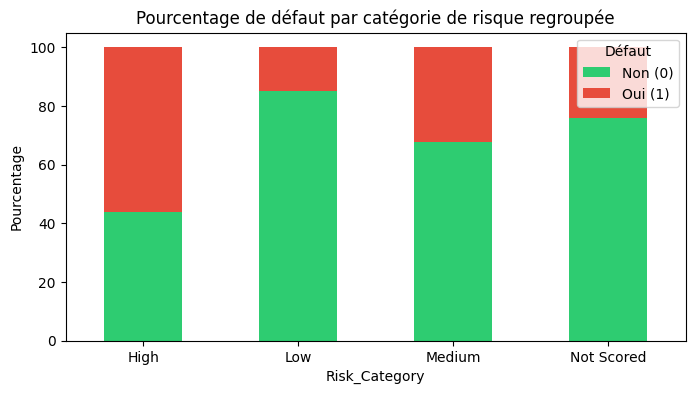

In [7]:
# Création de la fonction de mapping pour regrouper les risques
def map_risk_category(description):
    if pd.isna(description):
        return "Not Scored"

    desc = str(description)
    if 'Very Low Risk' in desc or 'Low Risk' in desc: # A to G
        return 'Low'
    elif 'Medium Risk' in desc: # H and I
        return 'Medium'
    elif 'High Risk' in desc or 'Very High Risk' in desc: # J to M
        return 'High'
    else:
        return 'Not Scored' # Tous les cas "Not Scored:..."

# Application du mapping
df['Risk_Category'] = df['PERFORM_CNS.SCORE.DESCRIPTION'].apply(map_risk_category)

#Enregistrement du dataframe pour partie quantification
df2=df.copy()

# érification : tableau croisé comme dans le html
# On regarde le lien entre nos nouvelles catégories et le défaut de paiement
risk_crosstab = pd.crosstab(df['Risk_Category'], df['loan_default'], normalize='index') * 100

print("Impact du regroupement des scores sur le défaut")
display(risk_crosstab.style.format("{:.1f}%").background_gradient(cmap='Reds', axis=1))

# Petit graphique pour illustrer ce tableau
risk_crosstab.plot(kind='bar', stacked=True, color=['#2ecc71', '#e74c3c'], figsize=(8, 4))
plt.title('Pourcentage de défaut par catégorie de risque regroupée')
plt.ylabel('Pourcentage')
plt.xticks(rotation=0)
plt.legend(title='Défaut', labels=['Non (0)', 'Oui (1)'])
plt.show()


L'analyse montre que le risque de défaut varie significativement selon la catégorie de risque.

Les emprunteurs catégorisés comme high risk ont un taux de défaut élevé, avec 56 % d'entre eux en défaut de paiement, ce qui est cohérent.

Ceux de la catégorie low risk ont un taux de défaut beaucoup plus faible, seulement 14,9 %.

La catégorie medium risk présente un taux de défaut intermédiaire, autour de 32,4 %.

Les emprunteurs Not Scored ont un taux de défaut de 24,1 %, ce qui est supérieur à la catégorie low mais inférieur à medium, cependant on ne peut pas savoir s'il s'agit de chance ou pas, on ne peut que le constater pour l'instant.

Le graphique, en pourcentage, confirme ces chiffres en montrant la proportion de défauts (en rouge) et de non-défauts (en vert) pour chaque groupe de risque.

Cette répartition confirme que le regroupement des scores de risque est pertinent pour prédire le défaut de paiement, avec un taux de défaut croissant selon la catégorie de risque.

---

Traitement des différentes dates à modifier





In [8]:
# Gestion de la Date de Naissance -> AGE
# On s'assure que Date.of.Birth est bien une date
df['Date.of.Birth'] = pd.to_datetime(df['Date.of.Birth'], format='%d/%m/%Y', errors='coerce')

# On calcule l'âge (référence 2018)
df['Age'] = 2018 - df['Date.of.Birth'].dt.year

# Gestion de la Date de Déboursement -> ANCIENNETÉ (Mois)
df['DisbursalDate'] = pd.to_datetime(df['DisbursalDate'], format='%d/%m/%Y', errors='coerce')

# On prend le 1er Novembre 2018 comme date de référence fictive pour l'exercice
# Comme on peut voir que les prêts vont jusqu'au 31/10/2018
ref_date = pd.Timestamp('2018-11-01')

# Calcul du nombre de mois (on divise la différence de temps par 30 jours approx)
df['Months_Since_Disbursal'] = ((ref_date - df['DisbursalDate']) / pd.Timedelta(days=30))

# Fonction de conversion des autres durées
def duration_to_months(duration_str):
    if pd.isna(duration_str): return 0
    match = re.search(r'(\d+)yrs\s+(\d+)mon', str(duration_str))
    if match:
        return int(match.group(1)) * 12 + int(match.group(2))
    return 0

# Création des variables pour qu'elles soient en mois maintenenant
df['CREDIT.HISTORY.LENGTH_Months'] = df['CREDIT.HISTORY.LENGTH'].apply(duration_to_months)
df['AVERAGE.ACCT.AGE_Months'] = df['AVERAGE.ACCT.AGE'].apply(duration_to_months)

# Affichage de contrôle (comme le tableau "Date.of.Birth | BorrowerAge..." de l'html)
cols_date_check = ['Date.of.Birth', 'Age', 'DisbursalDate', 'Months_Since_Disbursal','CREDIT.HISTORY.LENGTH', 'CREDIT.HISTORY.LENGTH_Months', 'AVERAGE.ACCT.AGE', 'AVERAGE.ACCT.AGE_Months']

print("Vérification des transformations temporelles")
display(df[cols_date_check].head())


Vérification des transformations temporelles


,Date.of.Birth,Age,DisbursalDate,Months_Since_Disbursal,CREDIT.HISTORY.LENGTH,CREDIT.HISTORY.LENGTH_Months,AVERAGE.ACCT.AGE,AVERAGE.ACCT.AGE_Months
0,1966-06-04,52,2018-10-23,0.300000,8yrs 9mon,105,3yrs 4mon,40
1,1987-02-24,31,2018-09-17,1.500000,2yrs 1mon,25,1yrs 0mon,12
2,1983-01-01,35,2018-09-28,1.133333,2yrs 11mon,35,1yrs 3mon,15
3,1990-06-30,28,2018-10-27,0.166667,2yrs 2mon,26,1yrs 1mon,13
4,1969-01-17,49,2018-10-11,0.700000,3yrs 0mon,36,1yrs 4mon,16


Les transformations temporelles du tableau ont été correctement effectuées. Les colonnes CREDIT.HISTORY.LENGTH et AVERAGE.ACCT.AGE ont été converties du format texte "Xyrs Ymon" en nombre de mois, par exemple 8yrs 9mon est devenu 105 mois. La colonne Months_Since_Disbursal indique le temps écoulé depuis le décaissement en années fractionnaires. L’âge correspond bien à la date de naissance. Ces conversions permettent de manipuler facilement les durées et les âges pour des analyses ou calculs ultérieurs.

---

### Visualisation des données travaillées

Prérequis pour visualisation des données travaillées

In [9]:
# Forcer le type numérique
cols_numeric = ['disbursed_amount', 'ltv', 'CREDIT.HISTORY.LENGTH_Months', 'AVERAGE.ACCT.AGE_Months']
for col in cols_numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Création des catégories de risque (Regroupement)
def map_risk(x):
    s = str(x)
    if 'Very Low' in s or 'Low' in s: return 'Low Risk'
    if 'Medium' in s: return 'Medium Risk'
    if 'High' in s: return 'High Risk'
    return 'Not Scored'
df['Risk_Category'] = df['PERFORM_CNS.SCORE.DESCRIPTION'].apply(map_risk)

# FONCTION POUR AJOUTER LES POURCENTAGES
def add_percentages(ax, feature_col, order=None):
    # 1. On récupère l'ordre des catégories affichées sur l'axe X
    if order:
        categories = order
    else:
        # Si pas d'ordre forcé, on lit les labels directement sur le graph
        categories = [item.get_text() for item in ax.get_xticklabels()]

    # 2. On calcule les totaux pour chaque catégorie
    # (Ex: Combien de 'Salaried' au total ?)
    totals = df[feature_col].value_counts().reindex(categories).values

    # 3. On parcourt les 'containers' (groupes de barres : vert puis rouge)
    for container in ax.containers:
        # On parcourt chaque barre individuelle
        for i, bar in enumerate(container):
            height = bar.get_height()
            # On récupère le total de la catégorie correspondante (i)
            total_category = totals[i]

            if total_category > 0 and height > 0:
                percentage = 100 * height / total_category
                # Ajout de l'annotation
                ax.annotate(f'{percentage:.1f}%',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),  # Décalage de 3 points vers le haut
                            textcoords="offset points",
                            ha='center', va='bottom',
                            fontsize=10, fontweight='bold', color='black')

Gérération des graphiques sous formes d'histogrammes

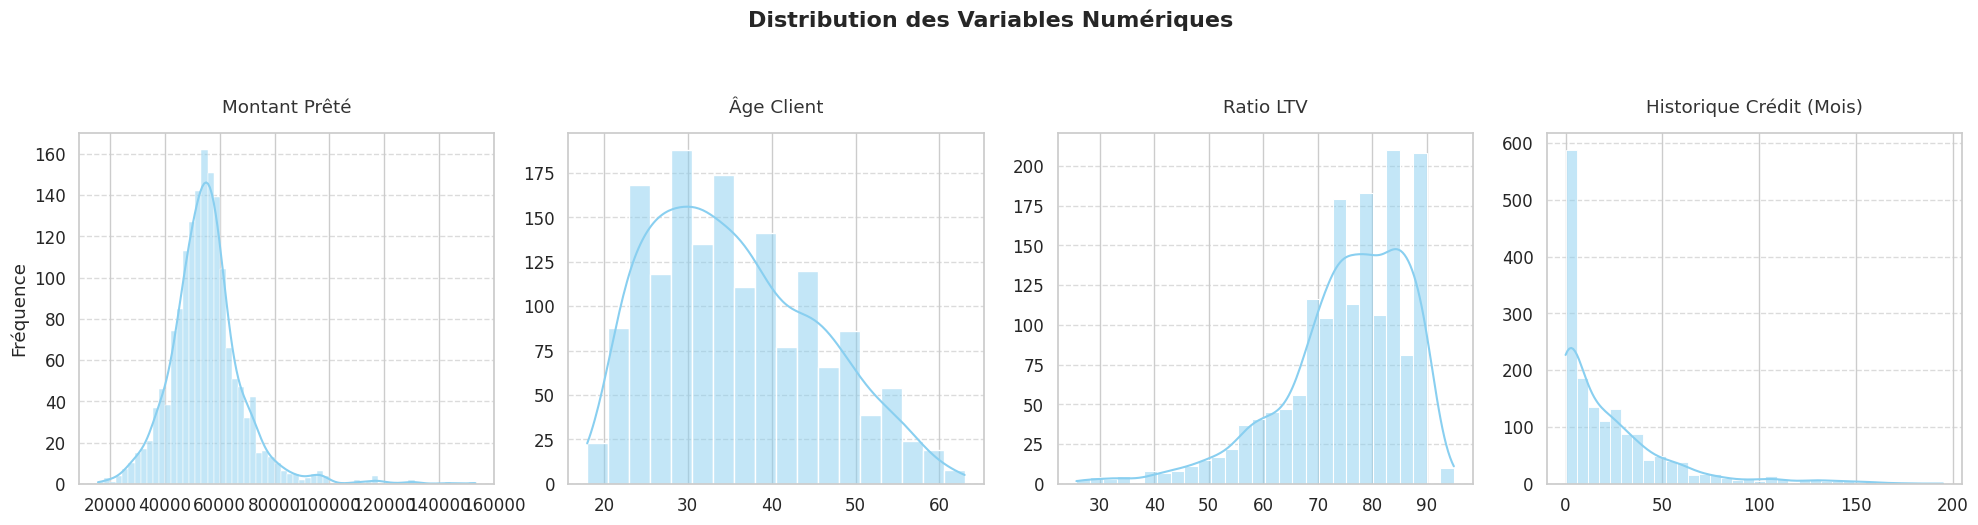

In [10]:

# Thème "R-style"
sns.set_theme(style="whitegrid", context="notebook", font_scale=1.1)

# DISTRIBUTION DES VARIABLES NUMÉRIQUES (Histogrammes)
vars_num = ['disbursed_amount', 'Age', 'ltv', 'CREDIT.HISTORY.LENGTH_Months']
titles_num = ['Montant Prêté', 'Âge Client', 'Ratio LTV', 'Historique Crédit (Mois)']

fig, axes = plt.subplots(1, 4, figsize=(20, 5)) # 1 ligne, 4 colonnes
fig.suptitle('Distribution des Variables Numériques', fontsize=16, fontweight='bold', y=1.05)

for i, col in enumerate(vars_num):
    # Histogramme avec courbe de densité (KDE) pour bien voir la forme
    sns.histplot(data=df, x=col, ax=axes[i], kde=True, color='#89CFF0', edgecolor='white')

    # Esthétique
    axes[i].set_title(titles_num[i], pad=15, color='#333333')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Fréquence' if i==0 else '') # On met "Fréquence" seulement au début pour alléger
    axes[i].grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

L'analyse des distributions univariées révèle le profil type des emprunteurs et des prêts.

La distribution est asymétrique à gauche (skewed). La majorité des prêts concerne des montants relativement faibles (probablement pour des deux-roues ou petites voitures), avec quelques montants très élevés qui étirent la distribution.

On observe une concentration forte vers des ratios élevés ltv (souvent entre 70% et 90%). Cela indique que les clients apportent peu d'apport personnel et financent la majeure partie du véhicule à crédit, ce qui peut constituer un facteur de risque.

Une part très importante des clients a un historique nul ou très court (proche de 0 mois). Ce sont des "primo-accédants" au crédit, pour lesquels il est difficile d'évaluer le comportement de remboursement passé.

Et enfin, par rapport à l'âge, on remarque que les clients ont généralement entre 25 à 40 ans, ce qui est tout à fait réaliste.

---

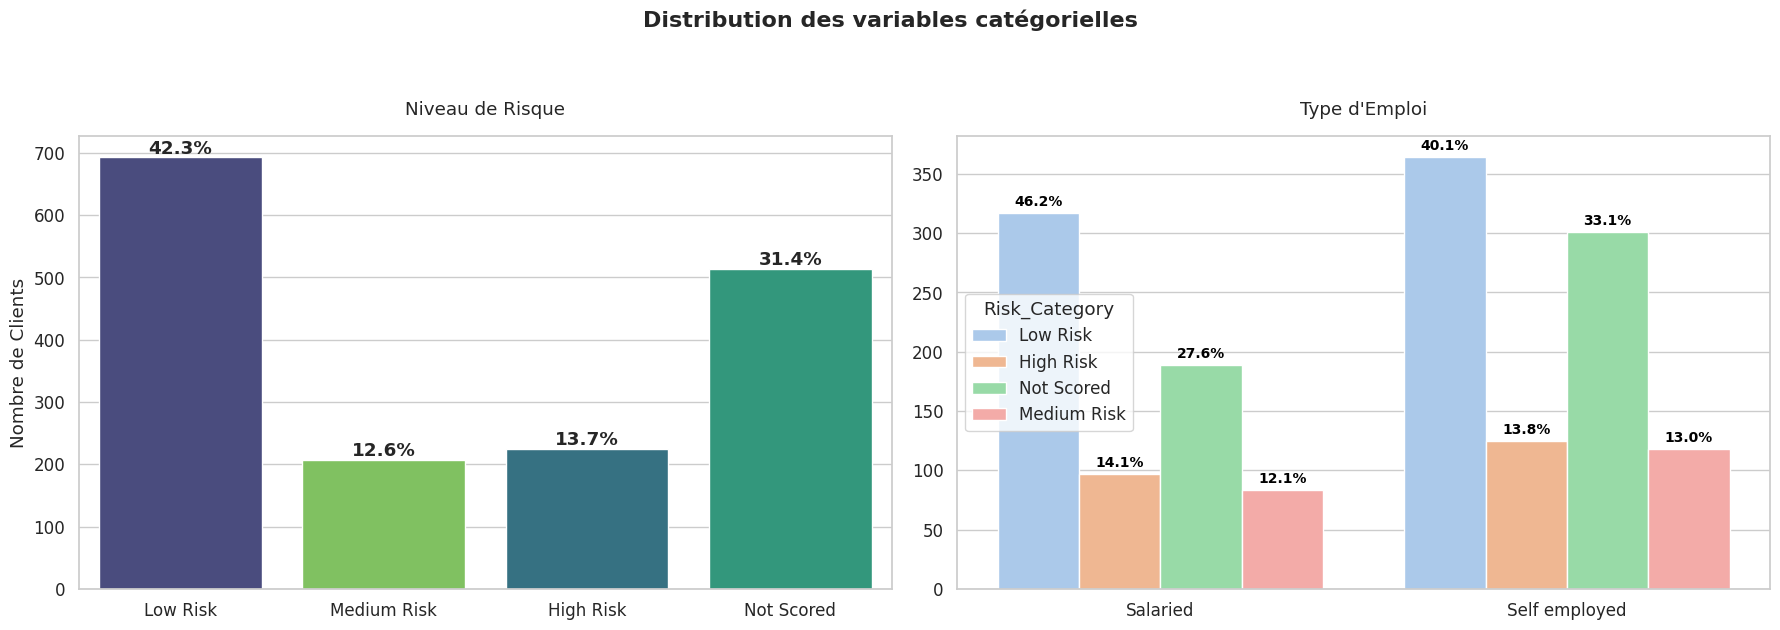

In [11]:
# DISTRIBUTION DES VARIABLES CATÉGORIELLES
vars_cat = ['Risk_Category', 'Employment.Type']
titles_cat = ['Niveau de Risque', 'Type d\'Emploi']

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Distribution des variables catégorielles', fontsize=16, fontweight='bold', y=1.05)

# Graphique 1 : Risque
order_risk = ['Low Risk', 'Medium Risk', 'High Risk', 'Not Scored']
sns.countplot(x='Risk_Category', hue='Risk_Category', data=df, ax=axes[0], order=order_risk, palette='viridis')
axes[0].set_title(titles_cat[0], pad=15)
axes[0].set_xlabel('')
axes[0].set_ylabel('Nombre de Clients')

total = df.shape[0]

for p in axes[0].patches:
    height = p.get_height()
    if height > 0:
        axes[0].annotate(
            f"{height / total * 100:.1f}%",
            (p.get_x() + p.get_width() / 2, height),
            ha='center',
            va='bottom',
            fontweight='bold'
        )
# Graphique 2 : Emploi
# On supprime les lignes qui étaient vides pour la variable Employment.Type
df = df.dropna(subset=['Employment.Type'])
sns.countplot(x='Employment.Type', hue='Risk_Category', data=df, ax=axes[1], palette='pastel')
axes[1].set_title(titles_cat[1], pad=15)
axes[1].set_xlabel('')
axes[1].set_ylabel('')

add_percentages(axes[1], 'Employment.Type')

plt.tight_layout()
plt.show()

Ce graphique pose le décor en montrant comment se répartit la population totale de vos clients. Il révèle une nouvelle rassurante : environ 42 % est classée en "low risk", ce qui indique une base de clientèle globalement saine. Cependant, il met en lumière une zone d'ombre majeure : la catégorie 'not scored'. Près d'un tiers des clients n'ont pas de score attribué. Cette absence de visibilité sur une si grande partie du portefeuille représente un enjeu stratégique, car comme vu dans les autres graphiques, ces profils non notés comportent un risque de défaut significatif qui n'est pas anticipé par le modèle actuel.

---

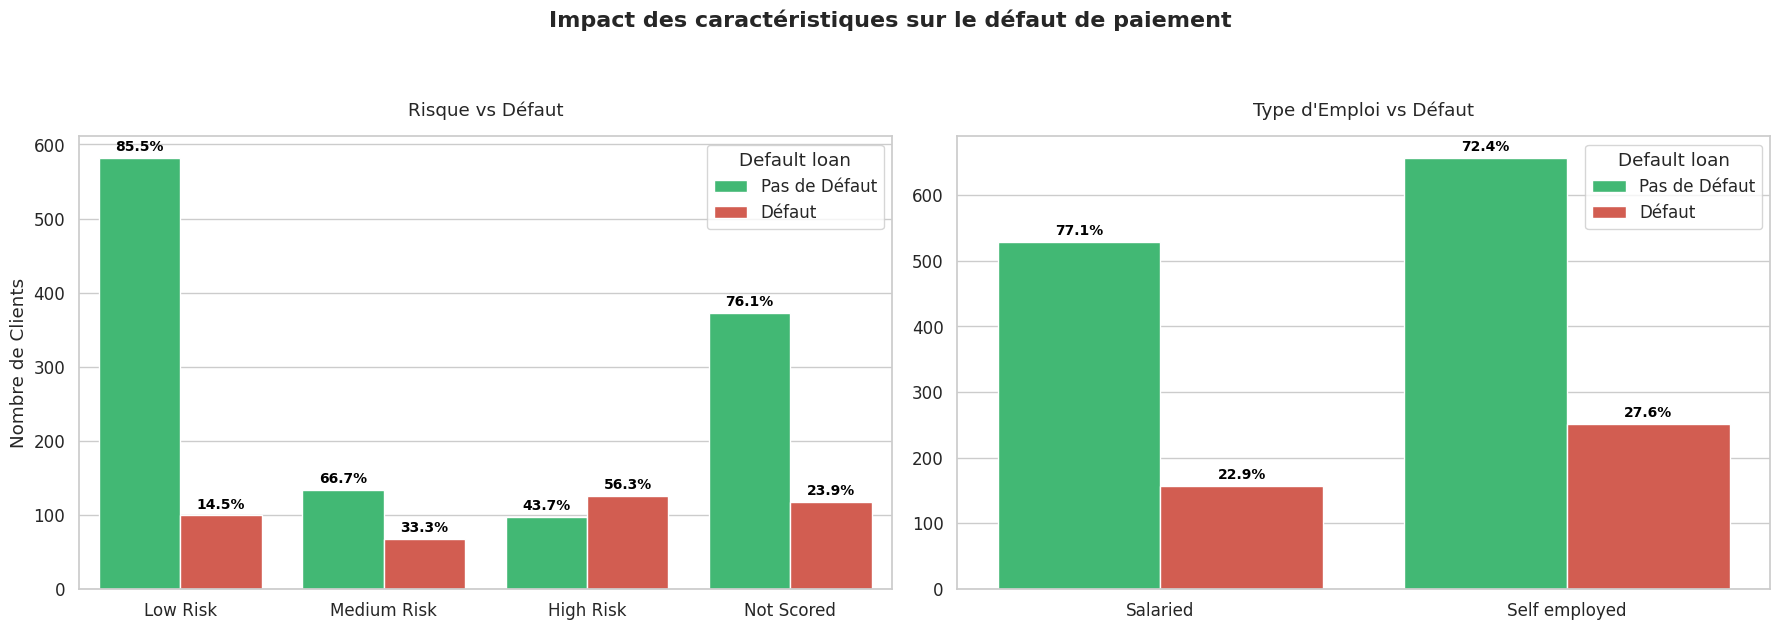

In [12]:
# On s'assure que la cible est bien lisible pour la légende
df['Statut'] = df['loan_default'].map({0: 'Pas de Défaut', 1: 'Défaut'})
# On remplit les manquants pour l'emploi
df['Employment.Type'] = df['Employment.Type'].fillna('Inconnu')

sns.set_theme(style="whitegrid", context="notebook", font_scale=1.1)

# On choisit deux caractéristiques clés
cat_features = ['Risk_Category', 'Employment.Type']
titles = ['Risque vs Défaut', 'Type d\'Emploi vs Défaut']

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Impact des caractéristiques sur le défaut de paiement', fontsize=16, fontweight='bold', y=1.05)

# Graphique 3 : Risk Category
# Ordre logique pour le risque
order_risk = ['Low Risk', 'Medium Risk', 'High Risk', 'Not Scored']

# countplot avec hue='Statut' crée les barres côte à côte
sns.countplot(x='Risk_Category', hue='Statut', data=df, ax=axes[0],
              order=order_risk, palette={'Pas de Défaut': '#2ecc71', 'Défaut': '#e74c3c'})

axes[0].set_title(titles[0], pad=15)
axes[0].set_xlabel('')
axes[0].set_ylabel('Nombre de Clients')
axes[0].legend(title='Default loan')

# Graphique 4 : Employment Type
sns.countplot(x='Employment.Type', hue='Statut', data=df, ax=axes[1],
              palette={'Pas de Défaut': '#2ecc71', 'Défaut': '#e74c3c'})

axes[1].set_title(titles[1], pad=15)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].legend(title='Default loan')

# Application de la fonction aux graphiques
add_percentages(axes[0], 'Risk_Category', order=order_risk)
add_percentages(axes[1], 'Employment.Type') # Pas d'ordre spécifique nécessaire ici

plt.tight_layout()
plt.show()

Ce visuel se concentre sur les volumes bruts de clients, mettant en opposition ceux qui remboursent (en vert) et ceux qui font défaut (en rouge). Il permet de valider visuellement la performance de votre modèle de scoring : dans la catégorie "high risk", la colonne rouge dépasse la verte, ce qui signifie qu'il y a plus de mauvais payeurs que de bons, confirmant que le modèle cible bien les profils dangereux. D'un autre côté, la comparaison par type d'emploi montre une masse de défauts (la surface rouge) visuellement beaucoup plus importante chez les indépendants que chez les salariés, bien que le nombre total de clients "self employed" ne soit pas radicalement supérieur. Cela souligne que le portefeuille des indépendants pèse plus lourdement dans les pertes globales de la banque.

---

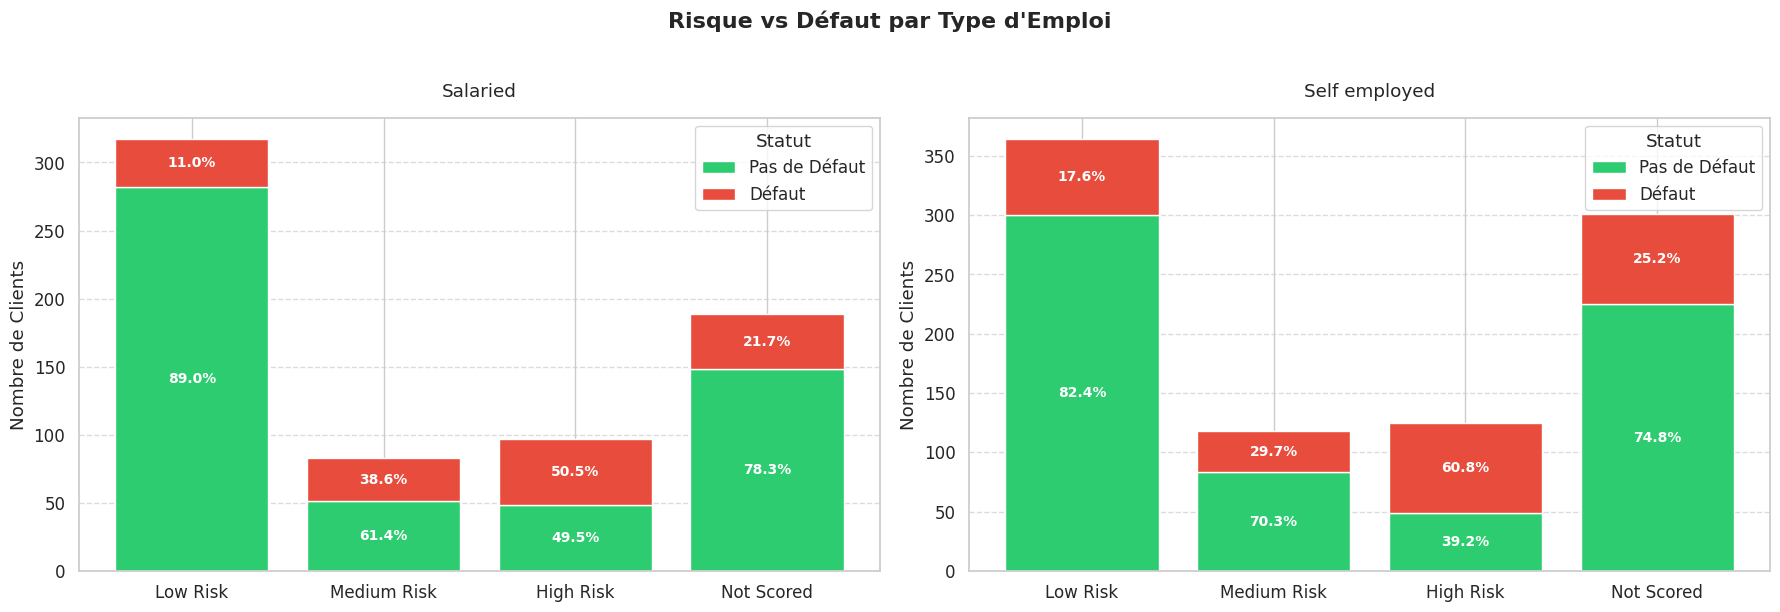

In [13]:
# Remplir les manquants
df['Statut'] = df['loan_default'].map({0: 'Pas de Défaut', 1: 'Défaut'})

# Thème seaborn
sns.set_theme(style="whitegrid", context="notebook", font_scale=1.1)

# Ordre des risques
order_risk = ['Low Risk', 'Medium Risk', 'High Risk', 'Not Scored']

# Couleurs
palette = {'Pas de Défaut': '#2ecc71', 'Défaut': '#e74c3c'}

# Figure avec facettes pour Employment.Type
employment_types = df['Employment.Type'].unique()
n_cols = min(3, len(employment_types))
n_rows = (len(employment_types) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6), squeeze=False)

for i, emp_type in enumerate(employment_types):
    ax = axes[i//n_cols, i%n_cols]
    df_emp = df[df['Employment.Type'] == emp_type]

    # Tableau croisé Risk_Category x Statut
    ct = pd.crosstab(df_emp['Risk_Category'], df_emp['Statut'])
    ct = ct.reindex(order_risk, fill_value=0)

    # Empiler les barres
    bottom = pd.Series([0]*len(ct), index=ct.index)
    for statut in ['Pas de Défaut', 'Défaut']:
        ax.bar(
            ct.index,
            ct[statut],
            bottom=bottom,
            color=palette[statut],
            label=statut
        )
        # Ajouter le % au centre de chaque segment
        for x, h, b in zip(ct.index, ct[statut], bottom):
            total = ct.loc[x].sum()
            if h > 0 and total > 0:
                percent = h / total * 100
                ax.text(
                    x,
                    b + h/2,
                    f"{percent:.1f}%",
                    ha='center',
                    va='center',
                    color='white',
                    fontsize=10,
                    fontweight='bold'
                )
        bottom += ct[statut]

    ax.set_title(emp_type, pad=15)
    ax.set_xlabel('')
    ax.set_ylabel('Nombre de Clients')
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    ax.tick_params(axis='x', rotation=0)
    ax.legend(title='Statut')

# Supprimer axes vides si besoin
for j in range(i+1, n_rows*n_cols):
    fig.delaxes(axes[j//n_cols, j%n_cols])

fig.suptitle("Risque vs Défaut par Type d'Emploi", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()



Ce graphique est sans doute le plus révélateur car il expose les probabilités précises de défaut pour chaque catégorie. L'analyse des pourcentages confirme que le statut d'indépendant ("self employed") constitue un facteur de risque aggravant par rapport au statut de salarié. À niveau de risque égal, les indépendants affichent systématiquement des taux de défaut supérieurs : par exemple, un profil "low risk" a 17,6 % de risque de défaut s'il est indépendant, contre seulement 11,0 % s'il est salarié. Cette tendance atteint un seuil critique dans la catégorie "High Risk", où plus de 60 % des indépendants font défaut. Par ailleurs, les clients classés "not scored" (non notés) présentent un risque non négligeable, avec des taux de défaut supérieurs à 20 %, ce qui prouve qu'une absence de notation cache souvent un profil plus risqué que la moyenne des bons clients, même si pour les salariés on a les mêmes tendances, mais avec des pourcentages de défauts plus importants dans n'importe quelle type de clients sur les risques

---

## Statistiques
Analyse des types de variables et des distributions principales.

# Deep dive

L’objectif de ce bloc de code est de nettoyer, transformer et diagnostiquer la variable Age, afin de vérifier qu’elle est :

cohérente économiquement,

exploitable pour un modèle de credit scoring,

exempte de valeurs aberrantes susceptibles de biaiser l’analyse statistique ou la modélisation.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# visuel config
sns.set_theme(style="whitegrid", context="notebook")

#notre func de nettoyage
def clean_numeric(x):
    if pd.isna(x): return np.nan
    if isinstance(x, (int, float)): return float(x)
    x = str(x).replace('"', '').replace(',', '').strip()
    try:
        return float(x)
    except:
        return np.nan

#load du fichierr
df = pd.read_csv("/content/sample_data/TD3 - 12Janv.csv")

# Nettoyage des colonnes critiques
cols_to_clean =["disbursed_amount", "asset_cost", "ltv", "PERFORM_CNS.SCORE"]
for col in cols_to_clean:
    if col in df.columns:
        df[col]=df[col].apply(clean_numeric)


In [15]:
# dob to age
df["Date.of.Birth"] =pd.to_datetime(df["Date.of.Birth"], format="%d/%m/%Y", errors="coerce")
REF_YEAR =2018
df["Age"] =REF_YEAR -df["Date.of.Birth"].dt.year
df.loc[(df["Age"] < 18) | (df["Age"] > 80), "Age"] = np.nan

# covert duree en mois
def convert_to_months(duration_str):
    if pd.isna(duration_str) or not isinstance(duration_str, str): return 0
    years = re.search(r'(\d+)yrs', duration_str)
    months=re.search(r'(\d+)mon', duration_str)
    total = 0
    if years:total +=int(years.group(1)) * 12
    if months: total += int(months.group(1))
    return total

df["CREDIT.HISTORY.LENGTH_Months"] =df["CREDIT.HISTORY.LENGTH"].apply(convert_to_months)
df["AVERAGE.ACCT.AGE_Months"]=df["AVERAGE.ACCT.AGE"].apply(convert_to_months)

Nous avons fait une fonction générique clean_numeric qui permet :

*supprimer les caractères parasites (sep de milliers par instance,),

*convertir les valeurs en float,

*transformer les valeurs non convertibles en NaN.

on l'applique a différentes variables financieres :disbursed_amount,asset_cost,ltv,PERFORM_CNS.SCORE.
l'enjeu est d'avoir une bonen structure de données pour ensuite obtenir :des statistiques descriptives fiables,des corrélations valides,une modélisation robuste.

on calcule Age de cette manuiere:

Age=2018−année de naissance


Un filtrage métier est ensuite appliqué :

Âge < 18 ans → oas cohérent pour un emprunteur

Âge > 80 ans → peu plausible dans nitre context

Logique de risk management : on impose un domaine réaliste correspondant à une population emprunteuse standard.

Les variables :

CREDIT.HISTORY.LENGTH

AVERAGE.ACCT.AGE
sont initialement stockées sous forme textuelle ("Xyrs Ymon").

Elles sont transformées en durées numériques exprimées en mois,
indispensable pour
comparer les durées entre individus,

les utiliser dans des modèles statistiques ou ML.

On utilise la méthode standard basée sur l’intervalle interquartile (IQR) :

Q1=25e  percentile

Q3=75e
 percentile

IQR=Q3−Q1


Les bornes théoriques sont :

Borne basse=Q1−1.5×IQR

Borne haute=Q3+1.5×IQR


In [16]:
q1, q3= df["Age"].quantile([0.25, 0.75])
iqr =q3-q1
low_fence, high_fence = q1 - 1.5*iqr, q3 + 1.5*iqr
outliers_n =((df["Age"] < low_fence) | (df["Age"] > high_fence)).sum()

print(f"Statistiques Age : Q1={q1:.1f} | Q3={q3:.1f} | IQR={iqr:.1f}")
print(f"Bornes Tukey : [{low_fence:.1f}, {high_fence:.1f}]")
print(f"Nombre d'outliers : {outliers_n}")


Statistiques Age : Q1=28.0 | Q3=43.0 | IQR=15.0
Bornes Tukey : [5.5, 65.5]
Nombre d'outliers : 0


Notre  Age a été construite à partir des dates de naissance, nettoyée selon des contraintes métier réalistes, puis analysée à l’aide de la règle de Tukey.
Les résultats montrent une distribution cohérente, centrée sur une population active, sans valeurs aberrantes détectées.
La variable est donc directement exploitable pour l’analyse descriptive et la modélisation du risque de défaut.

Pour chaque certaines numérique (Age, ltv, disbursed_amount), on procède en deux temps :

Statistiques descriptives globales

Niveau, dispersion, asymétrie potentielle

Analyse conditionnelle au défaut (loan_default)

Boxplot : médiane, dispersion, valeurs extrêmes

Violin plot : forme de la distribution et densité

ici notre objectif est d' identifier une capacité discriminante univariée entre emprunteurs en défaut (1) et non défaut (0).


---Analyse Univariée : Age ---


,count,mean,std,min,25%,50%,75%,max
Age,1639.0,35.552776,9.812752,18.0,28.0,34.0,43.0,63.0


/tmp/ipython-input-2386810953.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_df, x=col, y=target, ax=axes[0], palette="Set2")
/tmp/ipython-input-2386810953.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x=col, y=target, inner="box", ax=axes[1], palette="Pastel1")


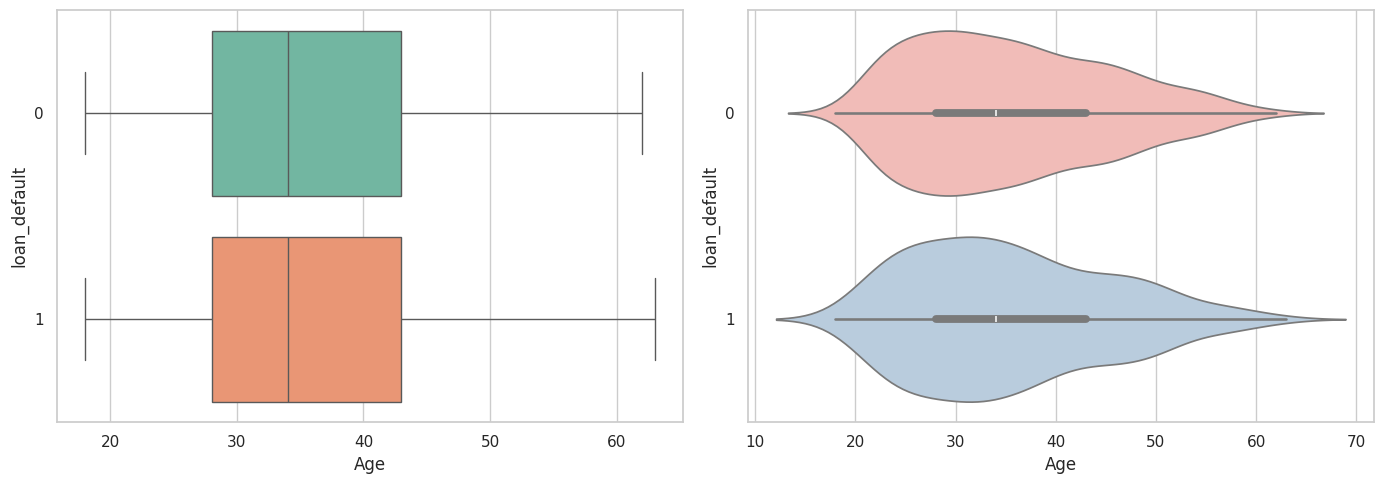


---Analyse Univariée : ltv ---


,count,mean,std,min,25%,50%,75%,max
ltv,1639.0,75.313801,11.553875,25.72,69.59,77.35,84.36,94.95


/tmp/ipython-input-2386810953.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_df, x=col, y=target, ax=axes[0], palette="Set2")
/tmp/ipython-input-2386810953.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x=col, y=target, inner="box", ax=axes[1], palette="Pastel1")


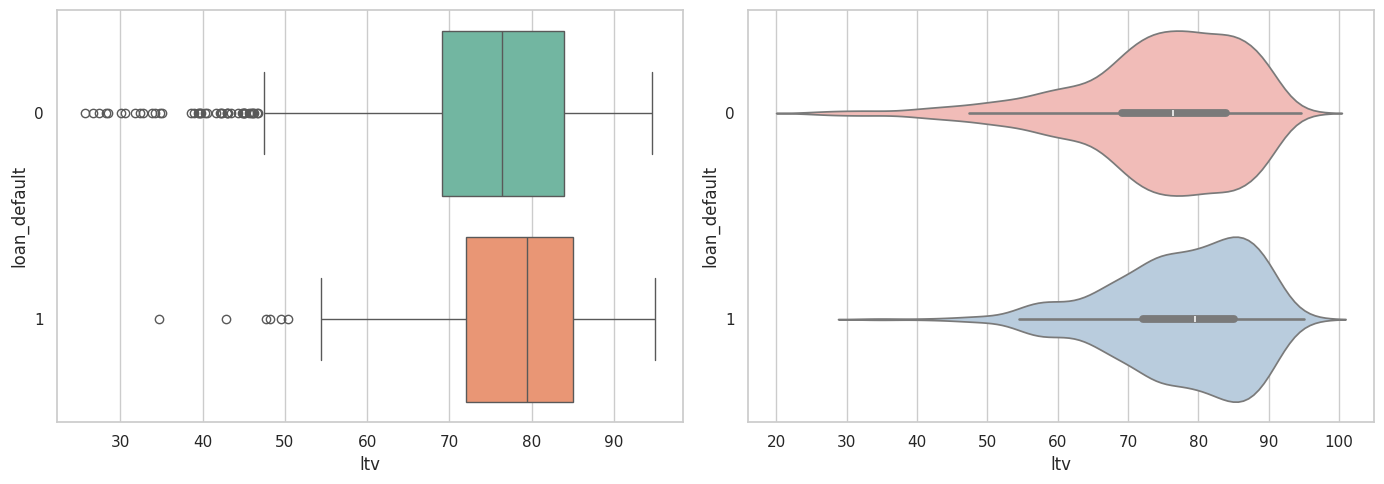


---Analyse Univariée : disbursed_amount ---


,count,mean,std,min,25%,50%,75%,max
disbursed_amount,1639.0,55199.85662,13344.671227,15579.0,47849.0,54513.0,60947.0,153318.0


/tmp/ipython-input-2386810953.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_df, x=col, y=target, ax=axes[0], palette="Set2")
/tmp/ipython-input-2386810953.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x=col, y=target, inner="box", ax=axes[1], palette="Pastel1")


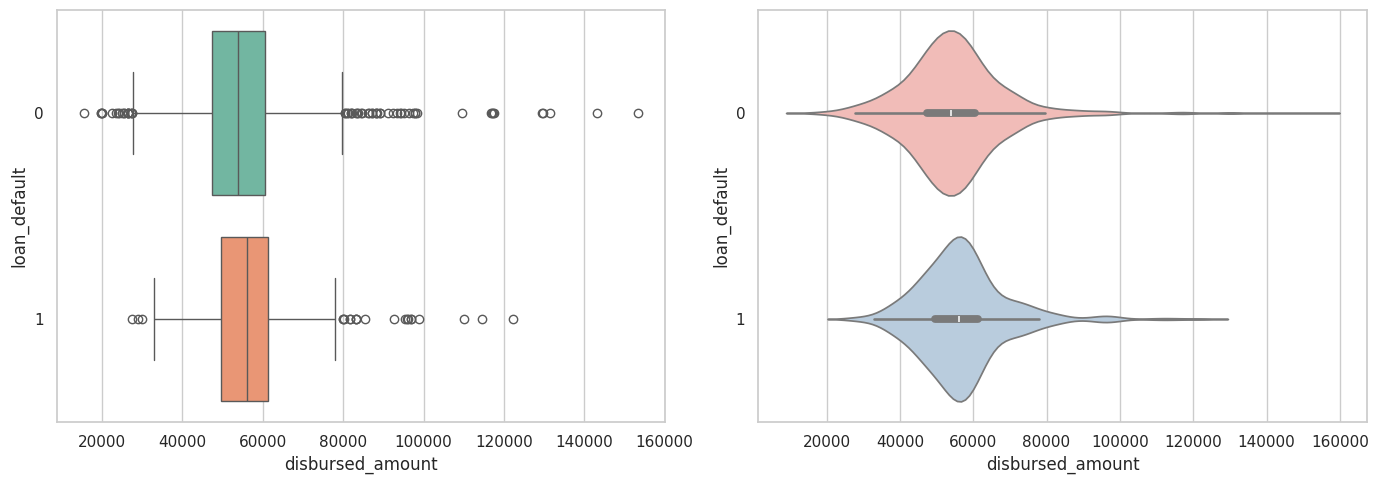

In [17]:
def univariate_numeric_analysis(df, col, target="loan_default"):
    print(f"\n---Analyse Univariée : {col} ---")
    display(df[col].describe().to_frame().T)
    plot_df=df[[col, target]].copy().dropna()
    plot_df[target] = plot_df[target].astype(str)
    fig, axes =plt.subplots(1, 2, figsize=(14, 5))
    sns.boxplot(data=plot_df, x=col, y=target, ax=axes[0], palette="Set2")
    sns.violinplot(data=plot_df, x=col, y=target, inner="box", ax=axes[1], palette="Pastel1")
    plt.tight_layout()
    plt.show()
for var in ["Age", "ltv","disbursed_amount"]:
    univariate_numeric_analysis(df, var)


## Analyse univariée des variables numériques

Cette section vise à analyser le comportement de certaines variables numériques (`Age`, `LTV`, `disbursed_amount`) (pas toutes comme demandés par vous) et leur relation avec la variable cible `loan_default`, afin d’évaluer leur capacité discriminante individuelle dans un contexte de credit scoring.

### Méthodologie
Pour chaque variable, on realise deux etapes
deja une analyse descriptive globale (moyenne, médiane, dispersion, valeurs extrêmes) ;
apres une analyse conditionnelle au défaut à l’aide de boxplots et de violin plots, permettant de comparer les distributions entre emprunteurs en défaut (`loan_default = 1`) et non défaut (`loan_default = 0`).

---

### 1. pour la variable age
on voir que la pop étudiée présente un âge moyen d’environ 36 ans, avec une médiane à 34 ans. La moitié des emprunteurs a un âge compris entre 28 et 43 ans, ce qui correspond à une population active économiquement.

on voit aussi que les boxplots et violin plots montrent des distributions très similaires entre les emprunteurs en défaut et non défaut. Les médianes et les intervalles interquartiles se chevauchent fortement, indiquant une faible capacité discriminante de l’âge pris isolément. L’âge ne constitue donc pas un déterminant univarié majeur du risque de défaut, bien qu’il puisse jouer un rôle indirect ou non linéaire en interaction avec d’autres variables.

---

### 2. Pour la variable LTV - ou loan to value
on voit que lle ratio LTV présente une différence notable entre les deux classes. Les emprunteurs en défaut affichent en moyenne un LTV plus élevé, avec une distribution décalée vers la droite et une dispersion plus importante.

on voit que ce resultat est économiquement cohérent : un LTV élevé traduit un apport initial plus faible et une marge de sécurité réduite pour la banque, augmentant mécaniquement le risque de défaut. Le LTV apparaît ainsi comme une variable fortement informative et un candidat central pour la modélisation du risque de crédit.

---

### 3.pour la var disbursed amount

enfin , Le montant déboursé présente une distribution asymétrique à droite, avec la présence de montants élevés rares. Les statistiques descriptives et les graphiques conditionnels montrent toutefois des distributions très proches entre emprunteurs en défaut et non défaut.

Le montant du prêt, pris isolément, ne permet donc pas de discriminer efficacement le risque de défaut. Son impact potentiel semble indirect et probablement capturé via des variables connexes telles que le LTV ou les revenus.

---

### Conclusion

notre analyse univariée met en évidence des capacités discriminantes contrastées selon les variables. Le LTV se distingue comme un déterminant clé du risque de défaut, tandis que l’âge et le montant du prêt présentent un pouvoir explicatif limité lorsqu’ils sont considérés individuellement. Ces résultats justifient une approche multivariée pour exploiter pleinement l’information contenue dans les données.


## Analyse WoE / IV des variables numériques

### notre methode :
Pr evaluer le pouvoir discriminant univarié des variables numériques, une analyse **Weight of Evidence (WoE)** et **Information Value (IV)** est réalisée.  
ainsi ,chaque variable est discrétisée automatiquement à l’aide de bornes basées sur les quantiles (quartiles), puis les proportions de défauts et de non-défauts sont comparées dans chaque intervalle.  
Le WoE permet d’identifier les segments associés à un risque plus élevé ou plus faible, tandis que l’IV mesure la capacité globale de la variable à discriminer le défaut.



In [18]:
def calculate_woe_iv(df, feature, target, bins):
    data = df[[feature, target]].copy().dropna()
    data["bin"] = pd.cut(data[feature], bins=bins, include_lowest=True)
    grouped =data.groupby("bin", observed=True)[target].agg(['count', 'sum'])
    grouped.columns= ['Total', 'Bads']
    grouped['Goods'] =grouped['Total'] - grouped['Bads']
    dist_bad =grouped['Bads'] / grouped['Bads'].sum()
    dist_good = grouped['Goods'] / grouped['Goods'].sum()
    grouped['WoE']=np.log((dist_good + 1e-6) / (dist_bad + 1e-6))
    grouped['IV'] =(dist_good - dist_bad) * grouped['WoE']
    return grouped.reset_index(), grouped['IV'].sum()

# ntre liste des varaibles a traiter
variables_to_bin= ["Age", "ltv", "PERFORM_CNS.SCORE"]

# 2.on va automatiquement creer les bins par quatile
bins_plan ={}

for var in variables_to_bin:
    quartiles = df[var].quantile([0, 0.25, 0.5, 0.75, 1.0]).unique()

    #cvrt en liste et force borne inf et sup
    # pr capturer toutes les futures
    bin_edges = list(quartiles)
    bin_edges[0] =-np.inf
    bin_edges[-1] =np.inf

    bins_plan[var] =bin_edges

#optional mais explciatif
for var, edges in bins_plan.items():
    print(f"Bins pour {var} : {edges}")


Bins pour Age : [-inf, np.float64(28.0), np.float64(34.0), np.float64(43.0), inf]
Bins pour ltv : [-inf, np.float64(69.59), np.float64(77.35), np.float64(84.36), inf]
Bins pour PERFORM_CNS.SCORE : [-inf, np.float64(566.0), np.float64(731.0), inf]


---

### Résultats
Les bornes obtenues montrent une segmentation cohérente des variables : voici ce que l on observe:
- **Age** est réparti en quatre classes équilibrées, mais présente un pouvoir discriminant limité.
- **LTV** affiche une différenciation plus marquée entre les segments, confirmant son rôle central dans l’explication du risque de défaut.
- **PERFORM_CNS.SCORE** est discrétisé en moins de classes en raison de valeurs répétées, ce qui reste suffisant pour capturer son effet informatif.


## Analyse du risque par tranche (binning quantiles) : lecture des graphiques

### Ce que l’on va faire maintenant
Pour chaque variable (`Age`, `ltv`, `PERFORM_CNS.SCORE`), on la discrétise en tranches (bins) à partir des quantiles, puis on calcule par tranche :
- la distribution de la population(barres bleues, en %) : part d’observations dans chaque tranche ;
- le taux de défaut (ligne rouge, en %) : \( \text{Bads} / \text{Total} \).

notre objectif est d’évaluer comment le risque de défaut varie selon les segments (lecture “business” du risque) et d’identifier les variables les plus discriminantes.

---

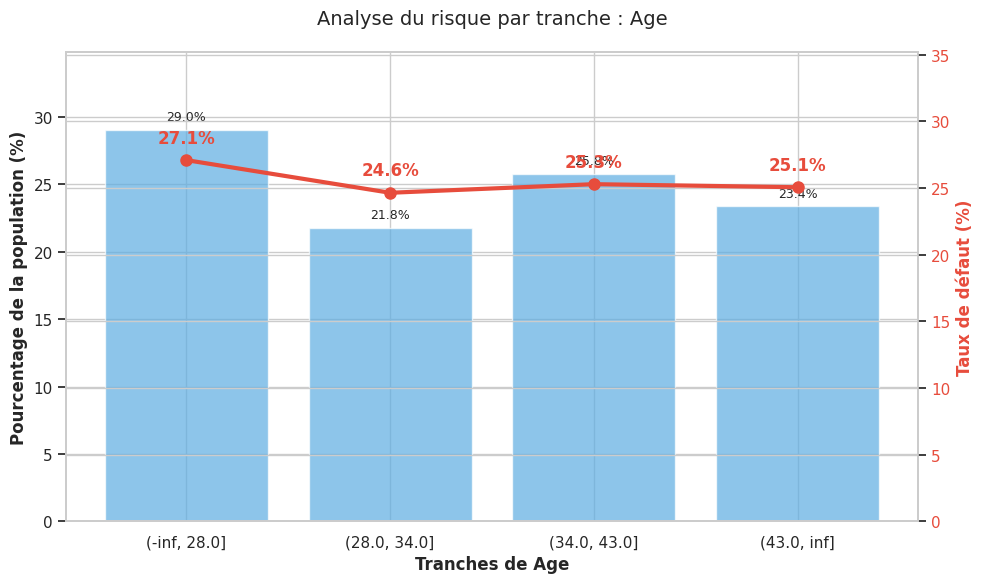

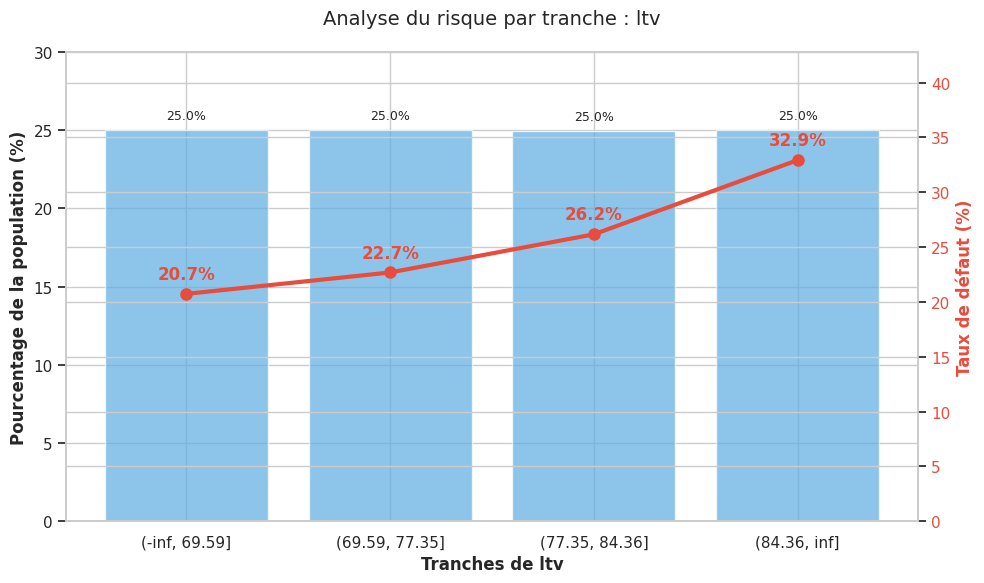

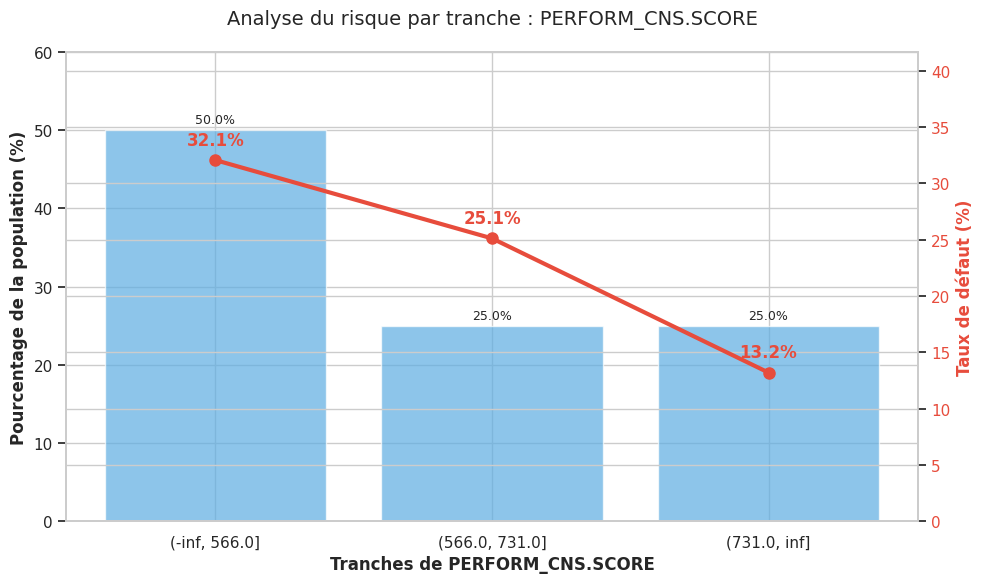

In [19]:
def woe_plot_percent(tbl, feature_name):
    #prep données
    labels =tbl["bin"].astype(str)
    total =tbl["Total"].sum()
    dist_pct =tbl["Total"] / total * 100
    bad_rate_pct=(tbl["Bads"] / tbl["Total"]) * 100

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # 1. Barres :distrib pop en %
    bars =ax1.bar(labels, dist_pct, color="#5DADE2", alpha=0.7, label="Distribution (%)")
    ax1.set_ylabel("Pourcentage de la population (%)", fontweight='bold')
    ax1.set_xlabel(f"Tranches de {feature_name}", fontweight='bold')
    ax1.set_ylim(0, max(dist_pct) * 1.2) # pr marge

    #% sur la barre
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, height + 0.5,
                 f"{height:.1f}%", ha="center", va="bottom", fontsize=9)

    # 2. Ligne : taux defaut ligne
    ax2 = ax1.twinx()
    ax2.plot(labels, bad_rate_pct, color="#E74C3C", marker="o", linewidth=3, markersize=8, label="Taux de défaut (%)")
    ax2.set_ylabel("Taux de défaut (%)", color="#E74C3C", fontweight='bold')
    ax2.tick_params(axis='y', labelcolor="#E74C3C")
    ax2.set_ylim(0, max(bad_rate_pct) * 1.3)

    # % ligne
    for x, y in zip(labels, bad_rate_pct):
        ax2.text(x, y + 1, f"{y:.1f}%", ha="center", va="bottom", color="#E74C3C", fontweight="bold")

    plt.title(f"Analyse du risque par tranche : {feature_name}", fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

# generation auto
for var in bins_plan.keys():
    stats_tbl, _ = calculate_woe_iv(df, var, "loan_default", bins_plan[var])
    woe_plot_percent(stats_tbl, var)

### Résultats et interprétation

**1) pr Age**
- Distribution assez équilibrée (≈ 22% à 29% par tranche).
- Taux de défaut proche dans toutes les tranches (≈ **24.6% à 27.1%**).
DONC **Conclusion :** l’âge discrimine peu le défaut en univarié (effet faible, pas de tendance nette).

**2) pr LTV**
- Tranches parfaitement équilibrées (≈ **25%** chacune, car bins par quartiles).
- Taux de défaut **croissant** avec le LTV : **20.7% → 22.7% → 26.2% → 32.9%**.
DONC **Conclusion :** relation claire et économiquement cohérente : **plus le LTV est élevé, plus le risque de défaut augmente**. Variable très informative.

**3) pr PERFORM_CNS.SCORE**
- Distribution non équilibrée : **50%** dans la tranche la plus basse (≤ 566), puis **25% / 25%**.
- Taux de défaut **décroissant fortement** avec le score : **32.1% → 25.1% → 13.2%**.
DONC **Conclusion :** le score est **fortement discriminant** : **score faible = risque élevé**, score élevé = risque faible.

---

### Synthèse
- **Variables les plus discriminantes :** `ltv` (tendance monotone croissante du risque) et `PERFORM_CNS.SCORE` (tendance monotone décroissante du risque).
- **Variable moins discriminante :** `Age` (taux de défaut quasi stable par tranche).

## PROCHAINE ETAPE : Classement des variables par Information Value (IV)

### Ce que l’on fait
Après avoir discrétisé chaque variable (`Age`, `ltv`, `PERFORM_CNS.SCORE`) en tranches basées sur les quantiles (quartiles), on calcule pour chaque variable :
- le **WoE** par tranche (comparaison de la proportion de non-défauts vs défauts),
- l’**Information Value (IV)**, qui agrège ces écarts sur l’ensemble des tranches et mesure le **pouvoir discriminant univarié** de la variable vis-à-vis de `loan_default`.

Ensuite, on classe les variables par IV décroissant et on interprète la “puissance” selon les seuils usuels (référentiel type Siddiqi) :
- IV < 0.02 : **Inutile**
- 0.02–0.10 : **Faible**
- 0.10–0.30 : **Moyenne**
- 0.30–0.50 : **Forte**
- > 0.50 : **Très forte** (attention : risque de fuite / surapprentissage)

---

In [20]:
# 1. bins par qquantile
variables_to_analyze =["Age", "ltv", "PERFORM_CNS.SCORE"]
bins_plan={}

for var in variables_to_analyze:
    q_edges = df[var].quantile([0, 0.25, 0.5, 0.75, 1.0]).unique().tolist()
    #secure les bornes
    q_edges[0] =-np.inf
    q_edges[-1] =np.inf
    bins_plan[var] = q_edges

# 2. Calcul de l'IV pour chaque variable
iv_results =[]

for var, bins in bins_plan.items():
    # function precedente
    stats_tbl, iv =calculate_woe_iv(df, var, "loan_default", bins)

    # interpret
    if iv < 0.02: strength = "Inutile"
    elif iv<0.1: strength = "Faible"
    elif iv < 0.3: strength = "Moyenne"
    elif iv <0.5: strength = "Forte"
    else: strength = "Très forte (Attention Overfitting)"

    iv_results.append({
        "Variable": var,
        "IV": round(iv, 4),
        "Puissance": strength,
        "Nb_Bins": len(bins) - 1
    })

# 3. classsement
ranking_df =pd.DataFrame(iv_results).sort_values("IV", ascending=False)

print("--- Résumé du Pouvoir Prédictif (IV) ---")
display(ranking_df)


--- Résumé du Pouvoir Prédictif (IV) ---


,Variable,IV,Puissance,Nb_Bins
2,PERFORM_CNS.SCORE,0.1865,Moyenne,3
1,ltv,0.0580,Faible,4
0,Age,0.0026,Inutile,4



### Résultats obtenus
Le classement IV met en évidence :

- **PERFORM_CNS.SCORE** : **IV = 0.1865** (Puissance Moyenne)  
  ➜ Variable la plus informative : elle discrimine correctement les défauts vs non-défauts.

- **ltv** : **IV = 0.0580** (Puissance Faible)))
  ➜ Variable utile mais pouvoir discriminant limité en univarié (effet réel mais modéré).

- **Age** : **IV = 0.0026** (Puissance Inutile)
  ➜ Variable non discriminante seule dans ce dataset : distributions très proches entre défaut et non-défaut.

Notre conclusion : en univarié, la variable la plus pertinente est `PERFORM_CNS.SCORE`, suivie de `ltv`. L’âge n’apporte quasiment pas d’information pour prédire le défaut pris isolément.


## Analyse de redondance des variables (V de Cramer)

### Ce que l’on fait
Après avoir transformé les variables numériques en variables catégorielles, on calcule le V de Cramer afin de mesurer la dépendance entre les variables explicatives, indépendamment de la variable cible.  
Le V de Cramer varie entre 0 et 1 : plus il est élevé, plus deux variables portent une information similaire.

L’objectif est double :
- identifier les variables redondantes (corrélation > 30 %),
- simplifier le modèle en conservant, pour chaque couple corrélé, la variable la plus liée à la cible `loan_default`.

---

Variables supprimées (redondance > 30%) :['AvgAge_bin', 'CreditHist_bin']
Variables finales sélectionnées : ['Employment.Type', 'Age_bin', 'ltv_bin', 'PERFORM_CNS.SCORE_bin', 'NewAccts_bin', 'Inquiries_bin']


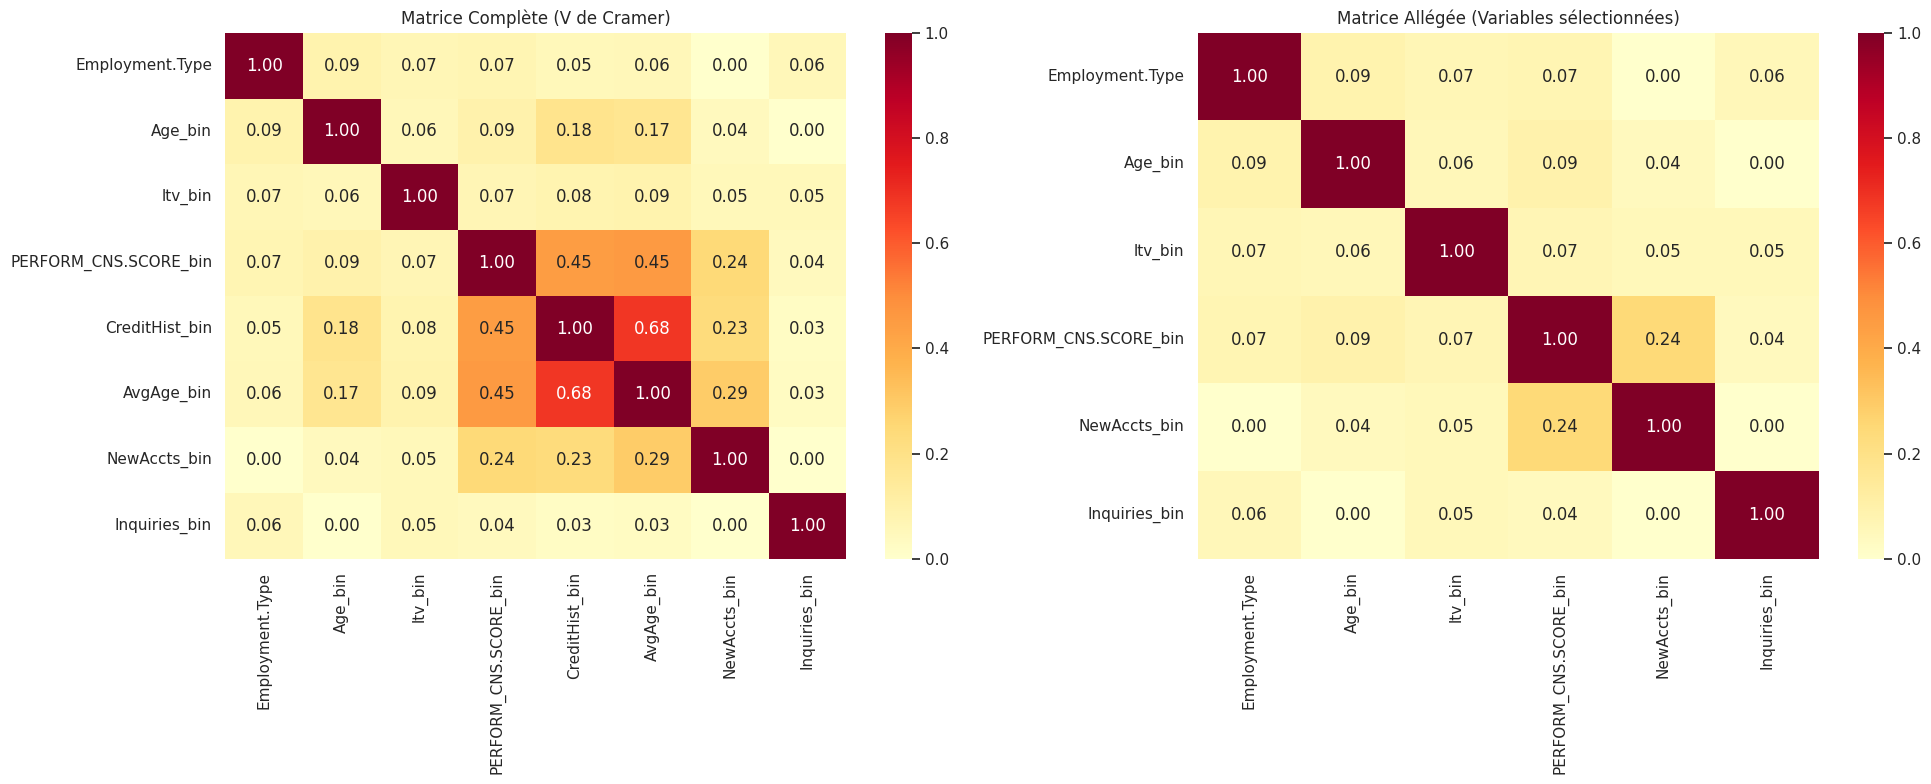

In [21]:
from scipy.stats import chi2_contingency

# 1prep colonnes temporelles
def convert_to_months(duration_str):
    if pd.isna(duration_str) or not isinstance(duration_str, str): return 0
    years= re.search(r'(\d+)yrs', duration_str)
    months =re.search(r'(\d+)mon', duration_str)
    total =0
    if years: total +=int(years.group(1)) * 12
    if months: total+= int(months.group(1))
    return total
df["CREDIT.HISTORY.LENGTH_Months"] =df["CREDIT.HISTORY.LENGTH"].apply(convert_to_months)
df["AVERAGE.ACCT.AGE_Months"]=df["AVERAGE.ACCT.AGE"].apply(convert_to_months)
# 2.tranches
df['Age_bin'] =pd.cut(df['Age'], bins=[-np.inf, 25, 35, 50, np.inf]).astype(str)
df['ltv_bin']= pd.cut(df['ltv'], bins=[-np.inf, 55, 73, 85, np.inf]).astype(str)
df['PERFORM_CNS.SCORE_bin'] =pd.cut(df['PERFORM_CNS.SCORE'], bins=[-np.inf, 300, 600, 750, np.inf]).astype(str)
df['CreditHist_bin']= pd.cut(df['CREDIT.HISTORY.LENGTH_Months'], bins=[-np.inf, 0, 12, 36, 60, np.inf]).astype(str)
df['AvgAge_bin'] =pd.cut(df['AVERAGE.ACCT.AGE_Months'], bins=[-np.inf, 0, 12, 36, 60, np.inf]).astype(str)
df['NewAccts_bin']= pd.cut(df['NEW.ACCTS.IN.LAST.SIX.MONTHS'], bins=[-np.inf, 0, 1, 3, np.inf]).astype(str)
df['Inquiries_bin'] =pd.cut(df['NO.OF_INQUIRIES'], bins=[-np.inf, 0, 1, 2, np.inf]).astype(str)

# var categorielles a test
cols_to_analyze=[
    "Employment.Type", "Age_bin", "ltv_bin", "PERFORM_CNS.SCORE_bin",
    "CreditHist_bin", "AvgAge_bin", "NewAccts_bin", "Inquiries_bin"
]

# 3. Foonction calcul v cramer
def cramers_v(x, y):
    confusion_matrix=pd.crosstab(x, y)
    chi2 =chi2_contingency(confusion_matrix)[0]
    n =confusion_matrix.sum().sum()
    phi2 =chi2 / n
    r, k= confusion_matrix.shape
    phi2corr =max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr =k -((k-1)**2)/(n-1)
    return np.sqrt(phi2corr /min((kcorr-1), (rcorr-1)))

# 4.matrix correlation intra modeles
corr_matrix =pd.DataFrame(index=cols_to_analyze, columns=cols_to_analyze)
for i in range(len(cols_to_analyze)):
    for j in range(len(cols_to_analyze)):
        corr_matrix.iloc[i, j] = cramers_v(df[cols_to_analyze[i]], df[cols_to_analyze[j]])
corr_matrix =corr_matrix.astype(float)

# 5. lien avec la cible pour arbitrage
target_corr = {var: cramers_v(df[var], df["loan_default"]) for var in cols_to_analyze}

# 6. selection couple >30%
to_drop =set()
threshold= 0.30
for i in range(len(cols_to_analyze)):
    for j in range(i + 1, len(cols_to_analyze)):
        if corr_matrix.iloc[i, j] >threshold:
            var1, var2 = cols_to_analyze[i], cols_to_analyze[j]
            # garde la plus correlee au defaut
            if target_corr[var1] >=target_corr[var2]:
                to_drop.add(var2)
            else:
                to_drop.add(var1)

selected_vars =[v for v in cols_to_analyze if v not in to_drop]

# 7. resultats
print(f"Variables supprimées (redondance > 30%) :{list(to_drop)}")
print(f"Variables finales sélectionnées : {selected_vars}")

# visualisations
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.heatmap(corr_matrix, annot=True, cmap="YlOrRd", fmt=".2f", ax=axes[0])
axes[0].set_title("Matrice Complète (V de Cramer)")

sns.heatmap(corr_matrix.loc[selected_vars, selected_vars], annot=True, cmap="YlOrRd", fmt=".2f", ax=axes[1])
axes[1].set_title("Matrice Allégée (Variables sélectionnées)")
plt.tight_layout()
plt.show()



### Résultats
La matrice complète met en évidence une forte corrélation entre :
- `CreditHist_bin` et `AvgAge_bin` (V ≈ 0.68),
- ainsi qu’un lien notable entre ces variables et `PERFORM_CNS.SCORE_bin`.

Sur la base du lien avec la cible, les variables suivantes sont **supprimées** pour éviter la redondance :
- `CreditHist_bin`
- `AvgAge_bin`

Les variables finales retenues sont :
- `Employment.Type`
- `Age_bin`
- `ltv_bin`
- `PERFORM_CNS.SCORE_bin`
- `NewAccts_bin`
- `Inquiries_bin`

Cette sélection permet d’obtenir un ensemble de variables moins corrélé, plus stable et mieux adapté à une modélisation de type scorecard ou régression logistique.


## Modèle final (Logistic Regression + WoE) et évaluation ROC/AUC

### Ce que l’on fait
À partir des variables catégorielles sélectionnées (`Employment.Type`, `Age_bin`, `ltv_bin`, `PERFORM_CNS.SCORE_bin`, `NewAccts_bin`, `Inquiries_bin`), on applique une transformation WoE (Weight of Evidence) à chaque modalité.  
Cette transformation convertit des catégories en valeurs numériques reflétant leur association au défaut, avec un **lissage** pour éviter les divisions par zéro et en incluant explicitement la modalité `"nan"`.

On entraîne ensuite une régression logistique sur les variables WoE, avec une séparation **train/test (70/30)** et un échantillonnage stratifié (même proportion de défauts dans train et test).  
La performance est évaluée via la **courbe ROC** et l’**AUC**, indicateur de capacité de discrimination du modèle.

---


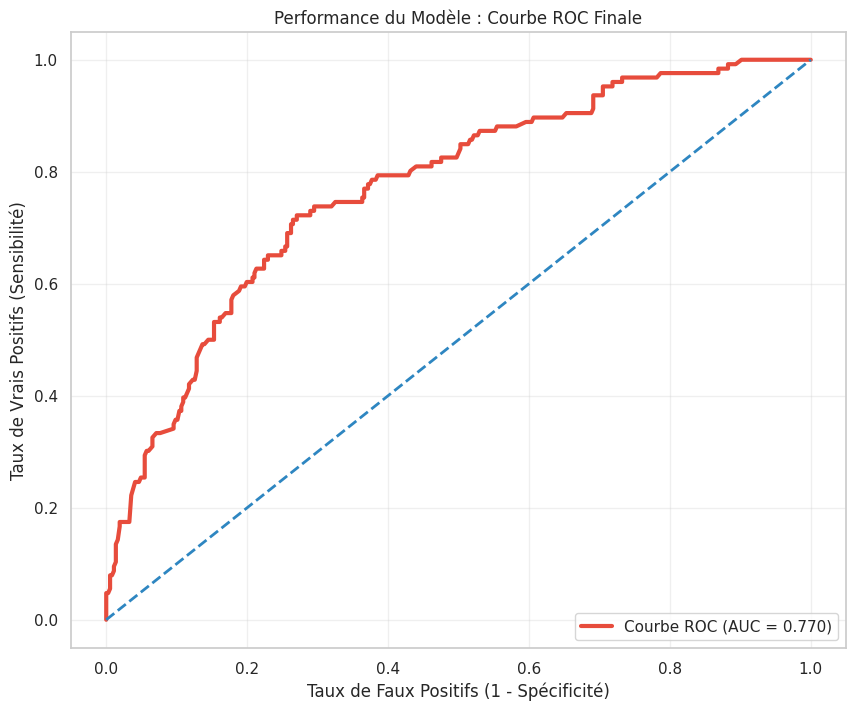

Score AUC Final : 0.7704


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

# 1.perp données et gestion nan
def apply_woe_safe(df, vars, target_col):
    for var in vars:
        #on s assure colonne enstring
        df[var] =df[var].astype(str)
        # stats par groupe
        stats =df.groupby(var)[target_col].agg(['count', 'sum'])
        total_g= (df[target_col]== 0).sum()
        total_b=(df[target_col] ==1).sum()
        # woe avec lissage
        stats['G_dist'] =(stats['count'] -stats['sum'] + 0.5) /total_g
        stats['B_dist']= (stats['sum'] + 0.5) /total_b
        woe_map=np.log(stats['G_dist'] / stats['B_dist']).to_dict()
        df[f"{var}_woe"]=df[var].map(woe_map)
    return df

# var selectionnes et transfo
selected_vars =['Employment.Type', 'Age_bin', 'ltv_bin', 'PERFORM_CNS.SCORE_bin', 'NewAccts_bin', 'Inquiries_bin']
df =apply_woe_safe(df, selected_vars, 'loan_default')

# training sans val manquanes
woe_cols= [f"{v}_woe" for v in selected_vars]
X =df[woe_cols]
y =df['loan_default']

X_train,X_test,y_train, y_test =train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

model = LogisticRegression()
model.fit(X_train, y_train)

#auc et courbe roc
y_probs = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ =roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='#E74C3C', lw=3, label=f'Courbe ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='#2E86C1', lw=2, linestyle='--')
plt.xlabel('Taux de Faux Positifs (1 - Spécificité)')
plt.ylabel('Taux de Vrais Positifs (Sensibilité)')
plt.title('Performance du Modèle : Courbe ROC Finale')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"Score AUC Final : {roc_auc:.4f}")




### Résultats
on observe que la courbe ROC est nettement au-dessus de la diagonale (modèle aléatoire), et l’on obtient :

- **AUC ≈ 0.770**

Notre interprétation : le modèle présente une bonne capacité discriminante Concrètement, il a environ 77% de probabilité d’attribuer un score plus élevé à un emprunteur en défaut qu’à un emprunteur non défaut (comparaison de paires aléatoires).  
Ce niveau d’AUC est cohérent avec un modèle de scoring “baseline” basé sur des variables bureau/financières transformées en WoE.


## Distribution des probabilités de défaut prédites

### Ce que l’on va faire
À partir du modèle final de **régression logistique **, on calcule les **probabilités de défaut prédites** sur le jeu de test.  
On compare ensuite la distribution de ces probabilités selon le **statut réel** des clients :
- **Bons clients** (`loan_default = 0`)
- **Mauvais clients** (`loan_default = 1`)

Les distributions sont représentées à l’aide de courbes de densité (KDE), et les **moyennes** de probabilité sont indiquées par des lignes verticales en pointillés.  
L’objectif est d’évaluer visuellement la **séparation des scores** entre les deux populations.

---


/tmp/ipython-input-3702827585.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_probs[y_test == 0],label='Bons Clients (Non-Défaut)',
/tmp/ipython-input-3702827585.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_probs[y_test == 1], label='Mauvais Clients (Défaut)',


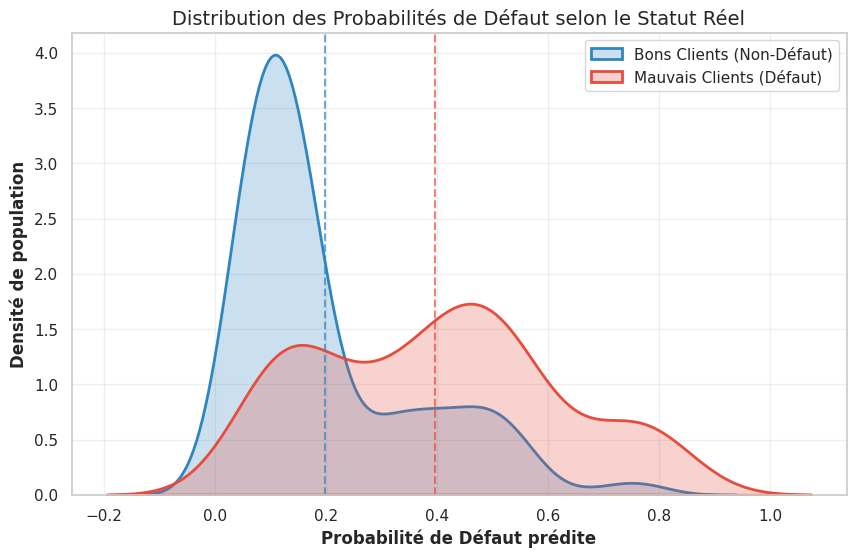

Probabilité moyenne - Bons Clients : 19.92%
Probabilité moyenne - Mauvais Clients : 39.72%


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. prob jeu de tets
y_probs=model.predict_proba(X_test)[:, 1]
# 2. graph distrib
plt.figure(figsize=(10, 6))

# distrib pour y=0
sns.kdeplot(y_probs[y_test == 0],label='Bons Clients (Non-Défaut)',
            shade=True, color='#2E86C1', lw=2)
# pr y=1 (mauvais client)
sns.kdeplot(y_probs[y_test == 1], label='Mauvais Clients (Défaut)',
            shade=True, color='#E74C3C',lw=2)
# ajout moyennes
plt.axvline(x=y_probs[y_test == 0].mean(),color='#2E86C1', linestyle='--', alpha=0.7)
plt.axvline(x=y_probs[y_test == 1].mean(), color='#E74C3C', linestyle='--', alpha=0.7)
#
plt.title('Distribution des Probabilités de Défaut selon le Statut Réel', fontsize=14)
plt.xlabel('Probabilité de Défaut prédite', fontweight='bold')
plt.ylabel('Densité de population', fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"Probabilité moyenne - Bons Clients : {y_probs[y_test == 0].mean():.2%}")
print(f"Probabilité moyenne - Mauvais Clients : {y_probs[y_test == 1].mean():.2%}")


---

### Résultats et interprétation
On observe un décalage net entre les deux distributions :
- Les bons clients présentent majoritairement des probabilités de défaut faibles, concentrées autour de valeurs basses.
- Les mauvais clients ont des probabilités de défaut plus élevées, avec une distribution décalée vers la droite.

Les probabilités moyennes confirment cette séparation :
- Probabilité moyenne (bons clients) : **≈ 20 %**
- Probabilité moyenne (mauvais clients) : **≈ 40 %**

**Conclusion :** le modèle attribue en moyenne des scores significativement plus élevés aux clients en défaut qu’aux clients non défaillants.  
Malgré un chevauchement partiel (inévitable en pratique), cette séparation est cohérente avec l’AUC obtenue (0.77) et confirme la capacité discriminante opérationnelle du modèle.


# 5 Quantification de la probabilité de défaut

## 5.1 Données et contexte

En nous appuyant sur la segmentation des risques définie précédemment, nous transformons le jeu de données initial pour agréger les taux de défaut par quinzaine, tout en conservant les effectifs par catégorie pour garantir la représentativité des échantillons. Ce passage au format pivoté permet de suivre l'évolution dynamique du risque pour chaque classe (Low, Medium, High, Not Scored).

In [24]:
df2.columns
print(df2['Risk_Category'],
df2['DisbursalDate'],
df2['loan_default'])

0              Low
1              Low
2             High
3              Low
4              Low
           ...    
1634          High
1635          High
1636           Low
1637          High
1638    Not Scored
Name: Risk_Category, Length: 1639, dtype: object 0       23/10/2018
1       17/09/2018
2       28/09/2018
3       27/10/2018
4       11/10/2018
           ...    
1634    16/10/2018
1635    11/10/2018
1636    25/09/2018
1637    09/10/2018
1638    06/09/2018
Name: DisbursalDate, Length: 1639, dtype: object 0       0
1       0
2       0
3       0
4       0
       ..
1634    1
1635    1
1636    1
1637    1
1638    1
Name: loan_default, Length: 1639, dtype: int64


In [25]:
# 1. Conversion forcée au format jour-mois-année
# dayfirst=True est crucial pour les datasets types LTFS/Indiens
df2['DisbursalDate'] = pd.to_datetime(df2['DisbursalDate'], dayfirst=True, errors='coerce')

# Supprimer les lignes où la date est manquante (si nécessaire)
df2 = df2.dropna(subset=['DisbursalDate'])

# 2. Grouper par Semaine et par Catégorie
# freq='W-MON' permet de commencer chaque semaine le Lundi (plus standard en banque)
ts_pivot = df2.groupby([pd.Grouper(key='DisbursalDate', freq='2W'), 'Risk_Category'])['loan_default'].agg(['mean', 'count']).unstack()

# 3. Aplatir les colonnes proprement
# On utilise une boucle plus lisible pour garantir l'ordre Taux1, Effectif1, Taux2, Effectif2...
new_columns = []
for cat in ts_pivot.columns.get_level_values(1).unique():
    new_columns.append(f"Taux_Défaut_{cat}")
    new_columns.append(f"Effectif_{cat}")

# On réorganise le dataframe pour avoir Taux et Effectif côte à côte pour chaque catégorie
ts_final = pd.DataFrame(index=ts_pivot.index)
for cat in ts_pivot['mean'].columns:
    ts_final[f"Taux_Défaut_{cat}"] = ts_pivot['mean'][cat]
    ts_final[f"Effectif_{cat}"] = ts_pivot['count'][cat]

# 4. Nettoyage
ts_final = ts_final.iloc[1:]  # Supprime la première semaine (souvent incomplète)
ts_final = ts_final.fillna(0) # Remplace les semaines sans prêts par 0

# 5. Affichage avec formatage pour les pourcentages
print("Aperçu des séries temporelles hebdomadaires :")
display(ts_final.head().style.format({col: "{:.2%}" for col in ts_final.columns if "Taux" in col}))

Aperçu des séries temporelles hebdomadaires :


,Taux_Défaut_High,Effectif_High,Taux_Défaut_Low,Effectif_Low,Taux_Défaut_Medium,Effectif_Medium,Taux_Défaut_Not Scored,Effectif_Not Scored
DisbursalDate,,,,,,,,
2018-08-05 00:00:00,50.00%,4.000000,7.69%,13.000000,50.00%,2.000000,33.33%,3.000000
2018-08-19 00:00:00,62.50%,32.000000,19.44%,72.000000,45.45%,11.000000,23.08%,26.000000
2018-09-02 00:00:00,46.43%,28.000000,8.85%,113.000000,58.82%,17.000000,33.33%,12.000000
2018-09-16 00:00:00,50.00%,26.000000,17.46%,63.000000,38.89%,18.000000,22.22%,9.000000
2018-09-30 00:00:00,60.00%,40.000000,13.18%,129.000000,33.33%,24.000000,33.33%,24.000000


## 5.2 Tracé des séries temporelles

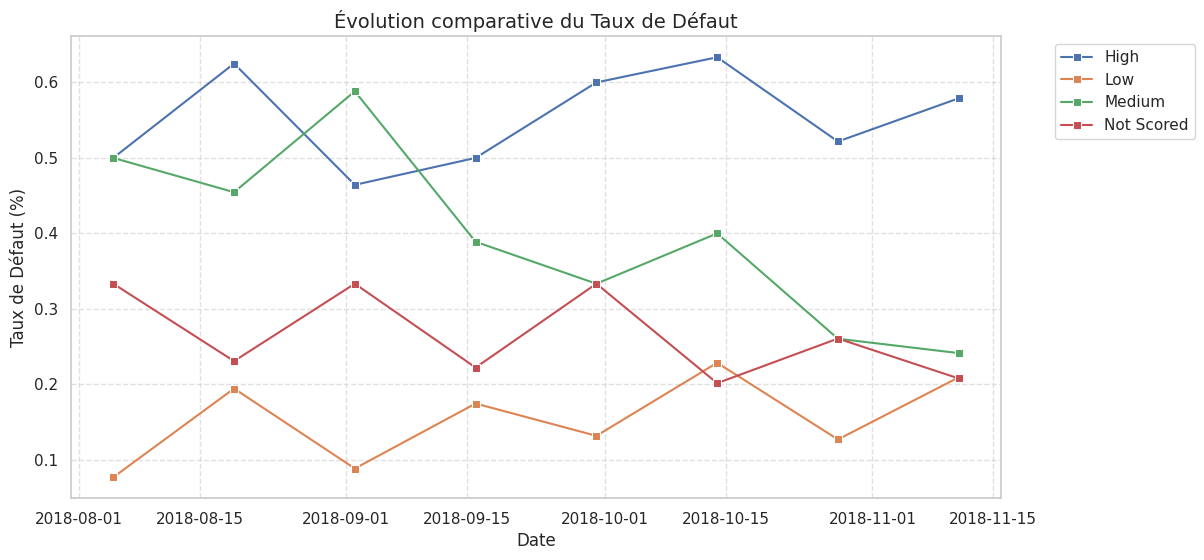

In [26]:
plt.figure(figsize=(12, 6))

# On filtre uniquement les colonnes de taux
cols_taux = [col for col in ts_final.columns if 'Taux' in col]

for col in cols_taux:
    sns.lineplot(data=ts_final, x=ts_final.index, y=col, label=col.replace('Taux_Défaut_', ''), marker='s')

plt.title('Évolution comparative du Taux de Défaut', fontsize=14)
plt.ylabel('Taux de Défaut (%)')
plt.xlabel('Date')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

L'examen du graphique révèle des dynamiques contrastées selon les segments de risque entre août et novembre 2018. On observe notamment une décroissance constante du taux de défaut pour la catégorie "Medium", qui semble converger vers les niveaux des catégories moins risquées en fin de période. À l'inverse, la catégorie "Low" affiche une légère tendance à la croissance, marquant une dégradation progressive de sa qualité de crédit initiale. Pour pallier la volatilité de ces séries, la méthodologie de calcul de la probabilité de défaut s'appuiera sur une approche prudente : la moyenne de la catégorie "Medium" sera stabilisée sur ses quatre premiers points afin de ne pas occulter le risque historique, tandis qu'une marge de conservatisme sera appliquée aux profils "Low" en mesurant l'écart entre les trois dernières observations et une projection linéaire établie sur les cinq premiers points.

## 5.3 Remédiation des points identfiés

### 5.3.1 Mise en forme des donnees

Pour faciliter l'analyse temporelle et la manipulation des données avec des bibliothèques comme Pandas ou Seaborn, nous transformons le DataFrame du format wide (une colonne par catégorie de risque) vers un format long (une colonne "Date", une colonne "Catégorie" et une colonne "Taux"), ce qui permet de regrouper et de filtrer les séries temporelles de manière plus flexible.

In [27]:
# 1. Reset l'index pour extraire la date
ts_reset = ts_final.reset_index()
date_col_name = ts_reset.columns[0] # Identifie si c'est 'DisbursalDate' ou 'index'

# 2. Séparer et transformer les Taux (ODR)
df_odr = ts_reset.melt(id_vars=[date_col_name],
                       value_vars=[c for c in ts_reset.columns if 'Taux' in c],
                       var_name='Classe', value_name='ODR')
df_odr['Classe'] = df_odr['Classe'].str.replace('Taux_Défaut_', '')

# 3. Séparer et transformer les Effectifs (NB)
df_nb = ts_reset.melt(id_vars=[date_col_name],
                      value_vars=[c for c in ts_reset.columns if 'Effectif' in c],
                      var_name='Classe', value_name='NB')
df_nb['Classe'] = df_nb['Classe'].str.replace('Effectif_', '')

# 4. Fusionner les deux sur Date et Classe
ts_long = pd.merge(df_odr, df_nb, on=[date_col_name, 'Classe'])

# 5. Renommer la colonne de date et trier
ts_long = ts_long.rename(columns={date_col_name: 'Date'})
ts_long = ts_long.sort_values(by=['Date', 'Classe']).reset_index(drop=True)

# Affichage du résultat final
print(ts_long.head(6))

        Date      Classe       ODR    NB
0 2018-08-05        High  0.500000   4.0
1 2018-08-05         Low  0.076923  13.0
2 2018-08-05      Medium  0.500000   2.0
3 2018-08-05  Not Scored  0.333333   3.0
4 2018-08-19        High  0.625000  32.0
5 2018-08-19         Low  0.194444  72.0


### Traitement de la tendance de la classe Low

Pour la classe Low Risk, nous allons isoler les cinq premiers points de la série pour modéliser la tendance théorique "stable" via une régression linéaire. Cette droite servira de référence pour mesurer l'écart avec les données observées sur le reste de la période, cet écart constituant la marge de conservatisme nécessaire pour couvrir l'instabilité du risque.

In [28]:
from sklearn.linear_model import LinearRegression
import numpy as np

# 1. Filtrer les données pour la classe Low
df_low = ts_long[ts_long['Classe'] == 'Low'].sort_values('Date').copy()

# 2. Préparer les variables (X = temps en jours pour la régression)
df_low['Days'] = (df_low['Date'] - df_low['Date'].min()).dt.days
X = df_low['Days'].values.reshape(-1, 1)
y = df_low['ODR'].values

# 3. Entraînement sur les 4 premiers points (Période stable)
X_train, y_train = X[:5], y[:5]
model = LinearRegression()
model.fit(X_train, y_train)

# 4. Prédiction sur le reste de la période (Période instable/suivante)
X_test = X[5:]
y_test_real = y[5:]
y_test_pred = model.predict(X_test)


# 5. Calcul de la marge de conservatisme (MoC)
# On calcule l'écart moyen quand le réel est supérieur à la prédiction
diff = y_test_real - y_test_pred
moc_low = np.mean(np.maximum(0, diff))

print(f"Marge de conservatisme (low Risk) : {moc_low:.4%}")

Marge de conservatisme (low Risk) : 3.3157%


### Marge d'estimation

Ce bloc de code implémente la calibration finale des probabilités de défaut (PD) en intégrant une approche de moyenne pondérée par les effectifs, garantissant que les périodes à fort volume de production pèsent davantage dans l'estimation. Pour la catégorie Medium, la moyenne historique pondérée est calculée exclusivement sur les quatre premiers points afin de ne pas sous-estimer le risque malgré la baisse récente des taux. Parallèlement, pour la catégorie Low, nous ajoutons à cette base pondérée la marge de conservatisme (moc_low) issue de la régression linéaire pour couvrir la tendance haussière observée.

In [29]:
# Paramètre de confiance (95%)
Z = 1.96

results = []

for classe in ts_long['Classe'].unique():
    # Isoler les données de la catégorie
    data_cat = ts_long[ts_long['Classe'] == classe].copy()

    # Sélection de la fenêtre temporelle
    if classe == 'Medium':
        # On restreint aux 4 premiers points comme convenu
        working_data = data_cat.iloc[:4]
    else:
        working_data = data_cat

    # Moyenne pondérée (Weighted LRA)
    # Formule : Somme(Taux * Effectif) / Somme(Effectifs)
    total_effectif = working_data['NB'].sum()
    if total_effectif > 0:
        lra_weighted = (working_data['ODR'] * working_data['NB']).sum() / total_effectif
    else:
        lra_weighted = working_data['ODR'].mean()

    # Marge d'estimation (MoC A)
    # Note : On conserve l'écart-type non pondéré pour rester prudent sur la volatilité
    n_obs = len(working_data)
    std_odr = working_data['ODR'].std()
    moc_estimation = Z * (std_odr / np.sqrt(n_obs)) if n_obs > 0 else 0

    # Marge de conservatisme (MoC B/C)
    # Issue de la régression linéaire calculée précédemment pour le segment Low
    moc_instability = moc_low if classe == 'Low' else 0

    # PD Finale Calibrée
    pd_final = lra_weighted + moc_estimation + moc_instability

    results.append({
        'Classe': classe,
        'LRA_Pondérée': lra_weighted,
        'MoC_Estimation': moc_estimation,
        'MoC_Instability': moc_instability,
        'PD_Finale': pd_final,
        'Volume_Total': total_effectif
    })

# Affichage des résultats
df_results = pd.DataFrame(results)
display(df_results.style.format({
    'LRA_Pondérée': '{:.2%}',
    'MoC_Estimation': '{:.2%}',
    'MoC_Instability': '{:.2%}',
    'PD_Finale': '{:.2%}',
    'Volume_Total': '{:,.0f}'
}))

,Classe,LRA_Pondérée,MoC_Estimation,MoC_Instability,PD_Finale,Volume_Total
0,High,56.00%,4.46%,0.00%,60.46%,225
1,Low,14.74%,3.90%,3.32%,21.95%,692
2,Medium,47.92%,8.21%,0.00%,56.12%,48
3,Not Scored,24.12%,4.09%,0.00%,28.21%,514


### Visualisation Finale

/tmp/ipython-input-411472032.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.1%}'.format(x) for x in plt.gca().get_yticks()])


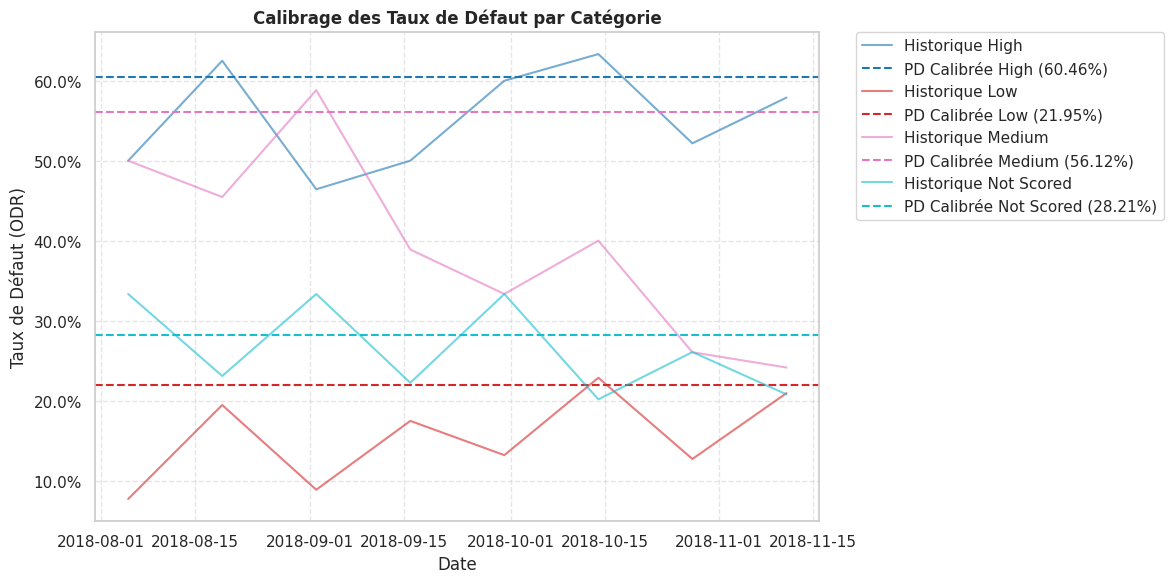

In [30]:
# 1. Configuration du style et de la figure
plt.figure(figsize=(12, 6))
plt.grid(True, linestyle='--', alpha=0.5)

# Définition des couleurs pour correspondre au graphique
colors = {
    'High': '#1f77b4',       # Bleu
    'Low': '#d62728',        # Rouge
    'Medium': '#e377c2',     # Rose
    'Not Scored': '#17becf'  # Cyan
}

# 2. Tracé des courbes
for classe in df_results['Classe']:
    # Récupération des données historiques
    data_plot = ts_long[ts_long['Classe'] == classe]
    pd_calibree = df_results.loc[df_results['Classe'] == classe, 'PD_Finale'].values[0]

    # Tracé de l'historique (ligne pleine)
    plt.plot(data_plot['Date'], data_plot['ODR'],
             label=f'Historique {classe}',
             color=colors[classe], alpha=0.6)

    # Tracé de la PD Calibrée (ligne horizontale pointillée)
    plt.axhline(y=pd_calibree,
                color=colors[classe], linestyle='--', linewidth=1.5,
                label=f'PD Calibrée {classe} ({pd_calibree:.2%})')

# 3. Formatage des axes et titres
plt.title('Calibrage des Taux de Défaut par Catégorie', fontweight='bold')
plt.ylabel('Taux de Défaut (ODR)')
plt.xlabel('Date')

# Formatage de l'axe Y en pourcentage
plt.gca().set_yticklabels(['{:.1%}'.format(x) for x in plt.gca().get_yticks()])

# Placement de la légende à l'extérieur
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()

La visualisation finale confirme que la hiérarchie des risques est scrupuleusement respectée, avec une gradation cohérente allant de la catégorie Low (21.95%) à la catégorie High (60.46%). L'approche méthodologique s'avère robuste : la PD calibrée pour les profils Low intègre efficacement la marge de conservatisme pour couvrir la tendance haussière de fin de période, tandis que la restriction du calcul aux quatre premiers points pour la catégorie Medium garantit une prudence accrue en ne répercutant pas la baisse récente des taux. Au final, l'ajout des marges d'estimation permet d'absorber la volatilité historique de chaque segment, offrant ainsi un modèle de risque de crédit sécurisé et conforme aux exigences de prudence.